![house](https://media3.giphy.com/media/W1fFapmqgqEf8RJ9TQ/giphy.gif?cid=ecf05e470iz6g7shmt0vw4fdp7mdgf5m8c5to7jy3dv1sold&ep=v1_gifs_search&rid=giphy.gif&ct=g)

### Introduction 

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

To show you the techniques, we'll start by picking a few variables using our intuition. Later tutorials will show you statistical techniques to automatically prioritize variables.

* Understand the problem: We'll look at each variable and do a philosophical analysis about their meaning and importance for this problem.
* Basic cleaning: We'll clean the dataset and handle the missing data, outliers and categorical variables.
* Exploratory Data Analysis:We'll create dummy variables for the categorical features, 
* Data Visualisation: We'll show data visualisation 
* Test assumptions: We'll check if our data meets the assumptions required by most multivariate techniques.

* Metric
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)


Now, it's time to have fun!

![Funny](https://media4.giphy.com/media/13Uqp5IGFpmDle/giphy.gif?cid=ecf05e47u3a8c3pm2tcnaemf80uz0qjyzq317yhiaf45gp7x&ep=v1_gifs_related&rid=giphy.gif&ct=g)

### Notebook Content:
1. [Part 1: Importing Necessary Libraries and datasets](#1)
1. [Part 2: Understanding the data](#2)
1. [Part 3: Feature Engineering](#3)
1. [Part 4: MODELLING](#4)



<a id='1'></a>
### Part 1:  Importing Necessary Libraries and datasets

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV


warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [4]:
# Read datasets 
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

#### Read and combine the Train and Test data sets. Proceed through the data you combined.

In [5]:
df = pd.concat([train, test], ignore_index=True)

<a id='2'></a>
### Part 2: Understanding the data

In [6]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())


In [7]:
check_df(df)

##################### Shape #####################
(2919, 81)
##################### Types #####################
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1       float64
BsmtFinType2  

#### CAPTURE OF NUMERICAL AND CATEGORICAL VARIABLES

In [8]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    grab_col_names for given dataframe

    :param dataframe:
    :param cat_th:
    :param car_th:
    :return:
    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    
    
     # cat_cols + num_cols + cat_but_car = number of variables.
     # num_but_cat is already in cat_cols.
     # so all variables will be selected with these 3 lists: cat_cols + num_cols + cat_but_car
     # num_but_cat is provided for reporting purposes only

    return cat_cols, cat_but_car, num_cols

cat_cols, cat_but_car, num_cols = grab_col_names(df)

Observations: 2919
Variables: 81
cat_cols: 52
num_cols: 28
cat_but_car: 1
num_but_cat: 10


#### Analysis of Categorical Variables 

In [9]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


for col in cat_cols:
    cat_summary(df, col)

          MSZoning  Ratio
MSZoning                 
RL            2265 77.595
RM             460 15.759
FV             139  4.762
RH              26  0.891
C (all)         25  0.856
        Street  Ratio
Street               
Pave      2907 99.589
Grvl        12  0.411
       Alley  Ratio
Alley              
Grvl     120  4.111
Pave      78  2.672
          LotShape  Ratio
LotShape                 
Reg           1859 63.686
IR1            968 33.162
IR2             76  2.604
IR3             16  0.548
             LandContour  Ratio
LandContour                    
Lvl                 2622 89.825
HLS                  120  4.111
Bnk                  117  4.008
Low                   60  2.055
           Utilities  Ratio
Utilities                  
AllPub          2916 99.897
NoSeWa             1  0.034
           LotConfig  Ratio
LotConfig                  
Inside          2133 73.073
Corner           511 17.506
CulDSac          176  6.029
FR2               85  2.912
FR3               14  

#### Analysis of Numerical Variables

count   2919.000
mean    1460.000
std      842.787
min        1.000
5%       146.900
10%      292.800
20%      584.600
30%      876.400
40%     1168.200
50%     1460.000
60%     1751.800
70%     2043.600
80%     2335.400
90%     2627.200
95%     2773.100
99%     2889.820
max     2919.000
Name: Id, dtype: float64


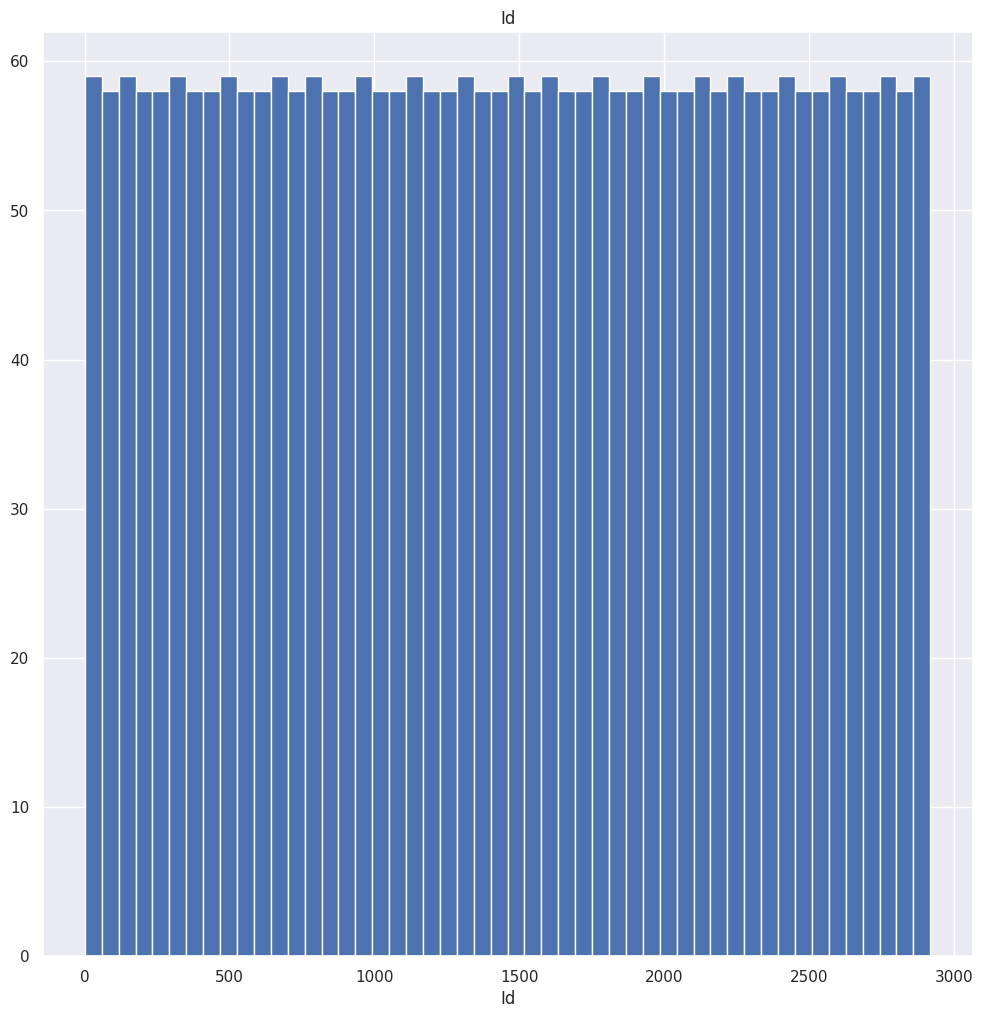

#####################################
count   2919.000
mean      57.138
std       42.518
min       20.000
5%        20.000
10%       20.000
20%       20.000
30%       20.000
40%       30.000
50%       50.000
60%       60.000
70%       60.000
80%       80.000
90%      120.000
95%      160.000
99%      190.000
max      190.000
Name: MSSubClass, dtype: float64


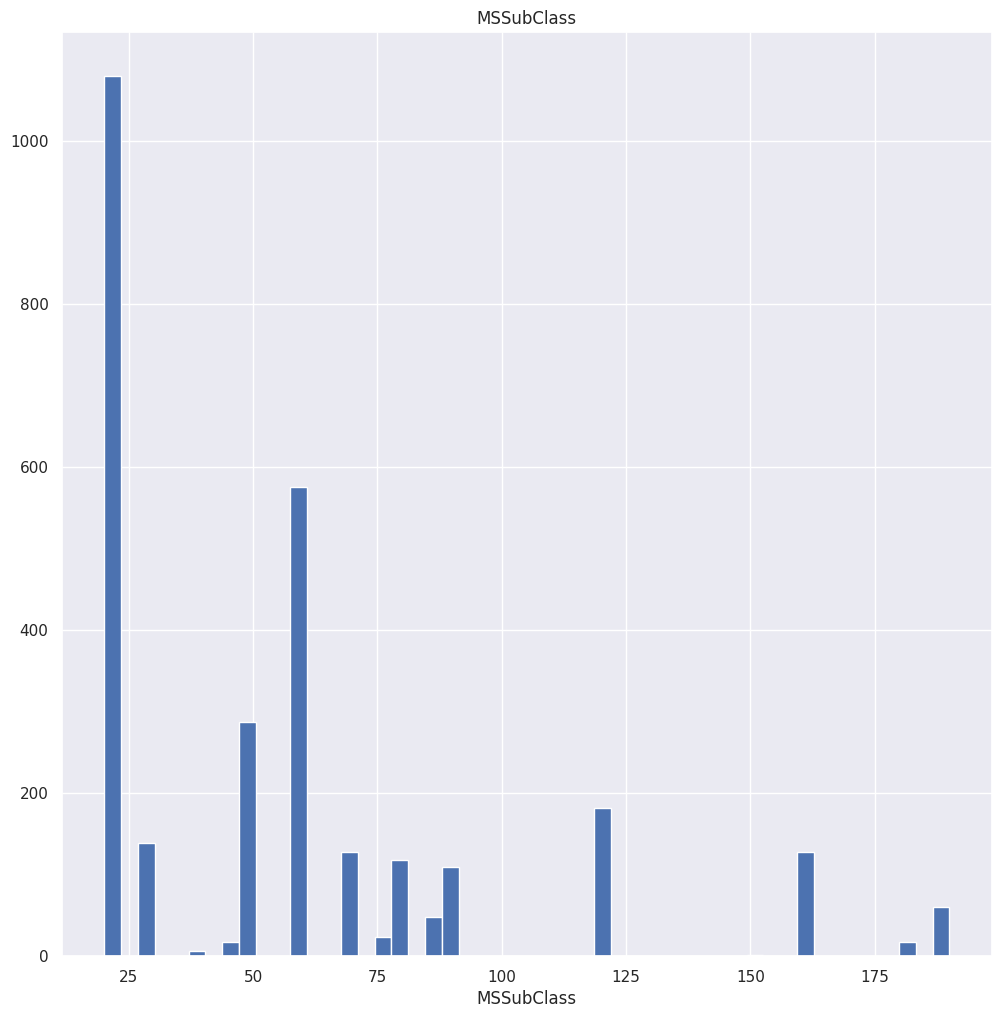

#####################################
count   2433.000
mean      69.306
std       23.345
min       21.000
5%        32.000
10%       43.000
20%       53.000
30%       60.000
40%       63.000
50%       68.000
60%       73.000
70%       78.000
80%       84.000
90%       95.000
95%      107.000
99%      135.680
max      313.000
Name: LotFrontage, dtype: float64


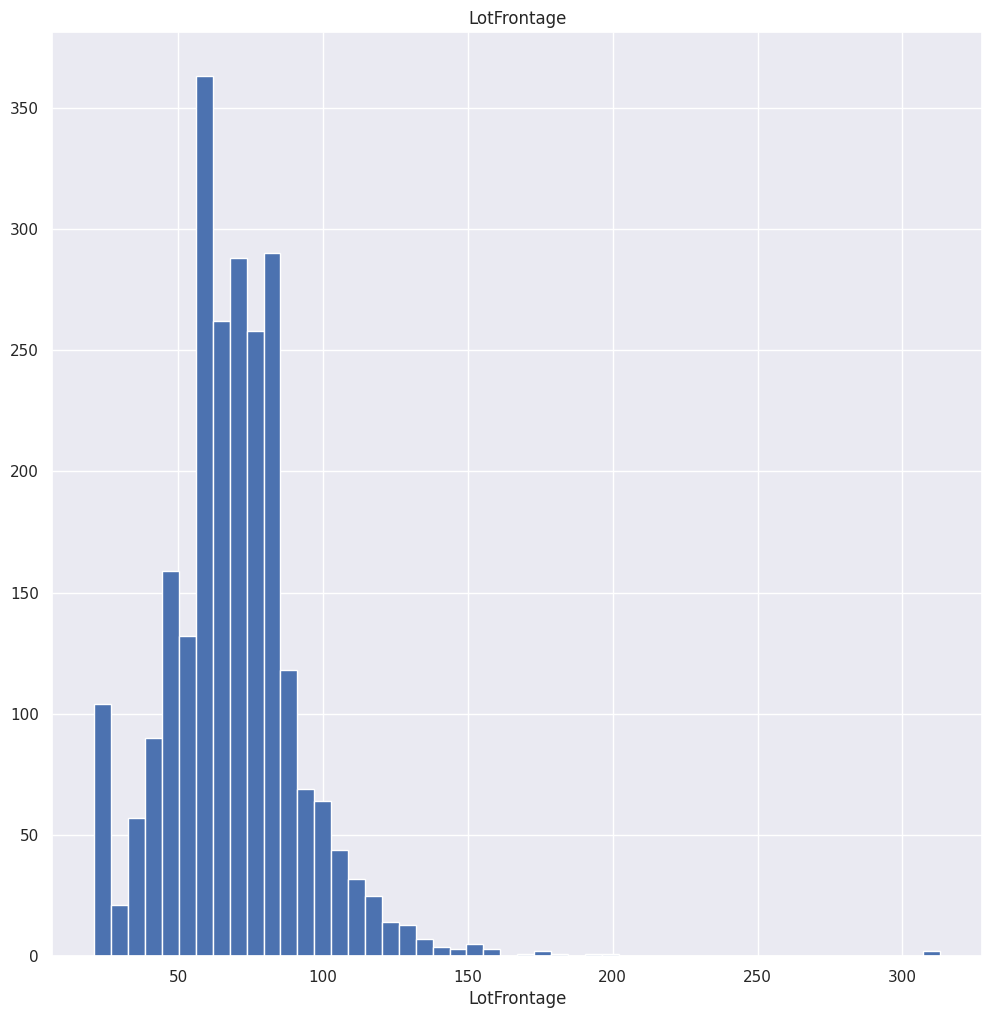

#####################################
count     2919.000
mean     10168.114
std       7886.996
min       1300.000
5%        3182.000
10%       4922.400
20%       7007.600
30%       7960.400
40%       8741.000
50%       9453.000
60%      10151.600
70%      11001.200
80%      12203.800
90%      14300.600
95%      17142.900
99%      33038.640
max     215245.000
Name: LotArea, dtype: float64


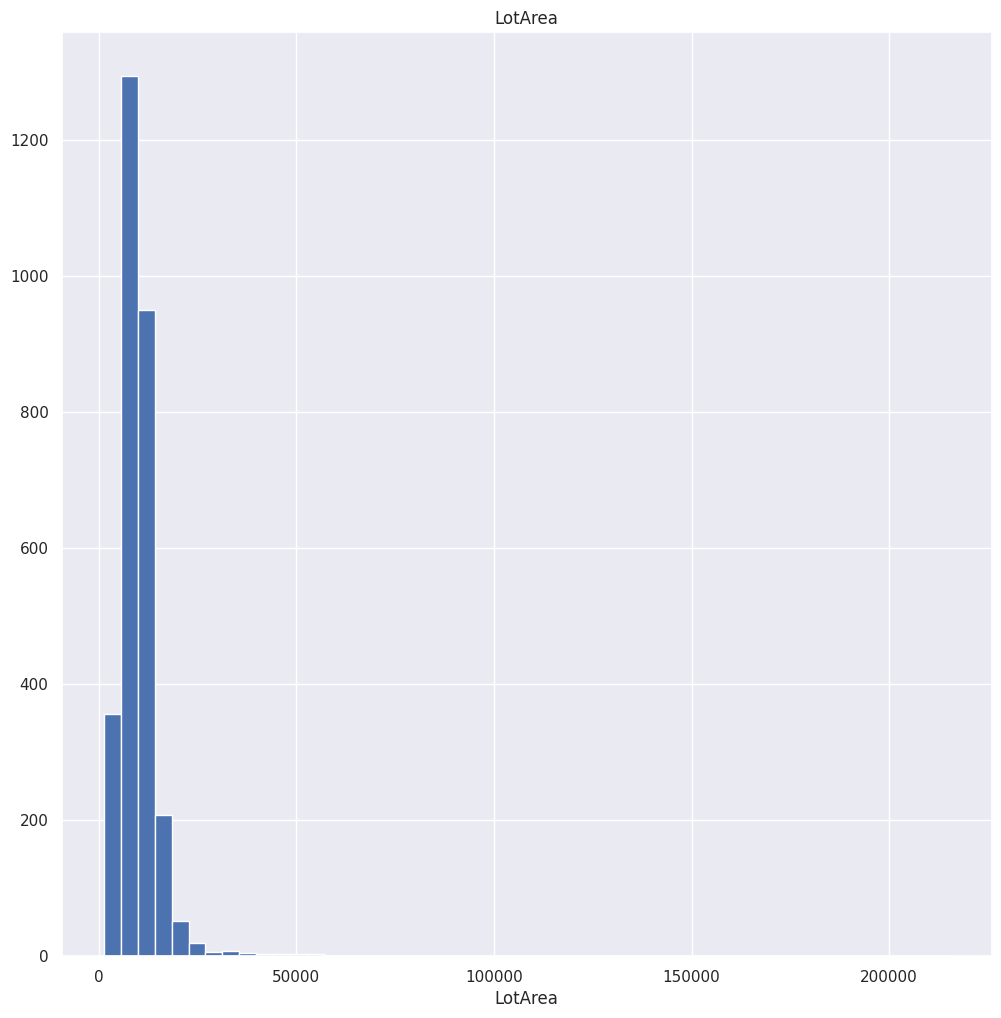

#####################################
count   2919.000
mean       6.089
std        1.410
min        1.000
5%         4.000
10%        5.000
20%        5.000
30%        5.000
40%        6.000
50%        6.000
60%        6.000
70%        7.000
80%        7.000
90%        8.000
95%        8.000
99%       10.000
max       10.000
Name: OverallQual, dtype: float64


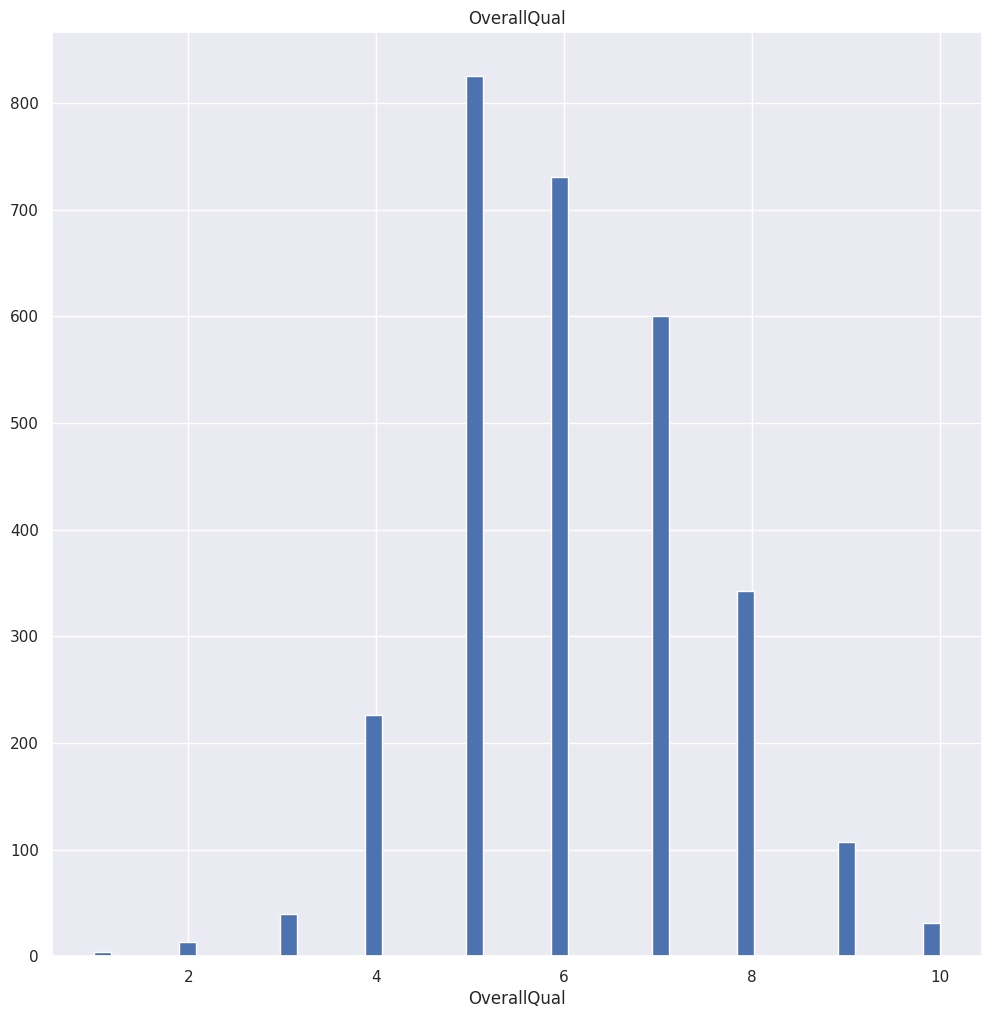

#####################################
count   2919.000
mean    1971.313
std       30.291
min     1872.000
5%      1915.000
10%     1924.000
20%     1947.000
30%     1957.000
40%     1965.000
50%     1973.000
60%     1984.000
70%     1998.000
80%     2003.000
90%     2006.000
95%     2007.000
99%     2008.000
max     2010.000
Name: YearBuilt, dtype: float64


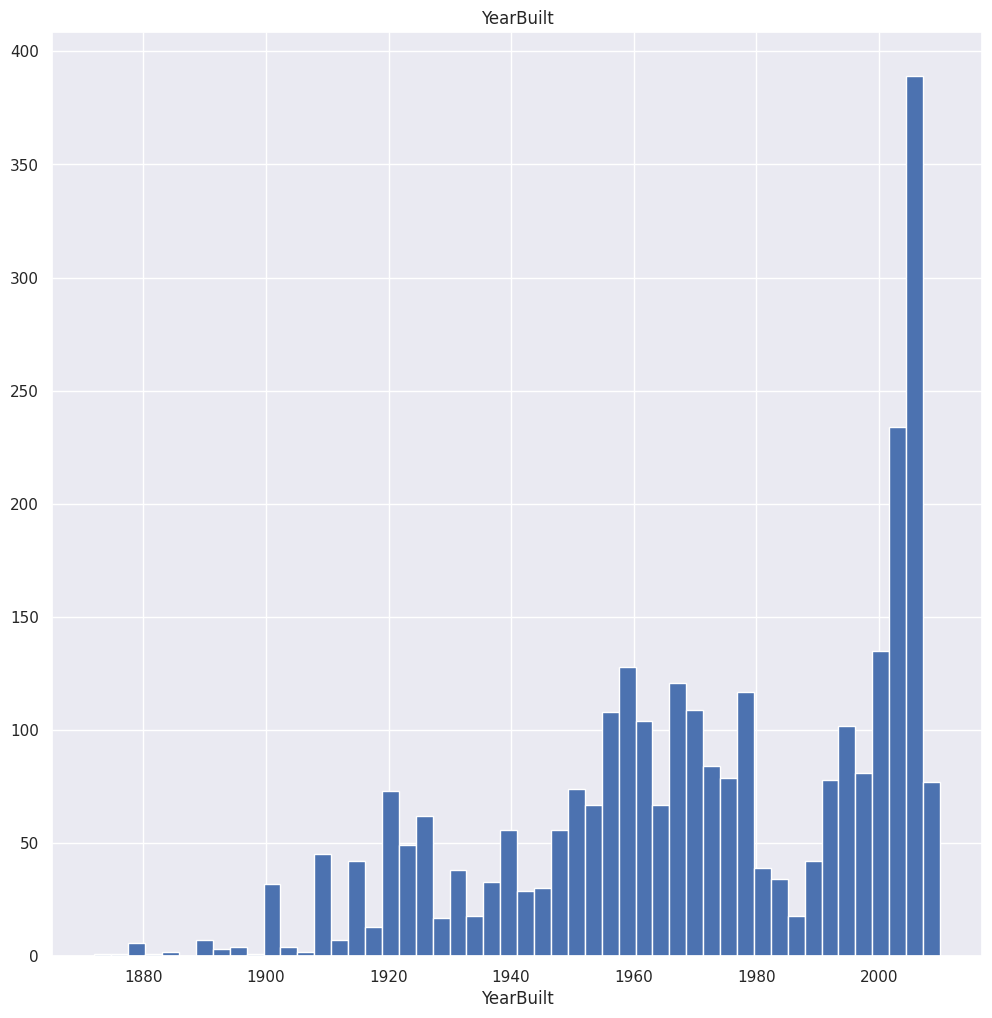

#####################################
count   2919.000
mean    1984.264
std       20.894
min     1950.000
5%      1950.000
10%     1950.000
20%     1960.000
30%     1970.000
40%     1978.000
50%     1993.000
60%     1998.000
70%     2002.000
80%     2005.000
90%     2006.200
95%     2007.000
99%     2009.000
max     2010.000
Name: YearRemodAdd, dtype: float64


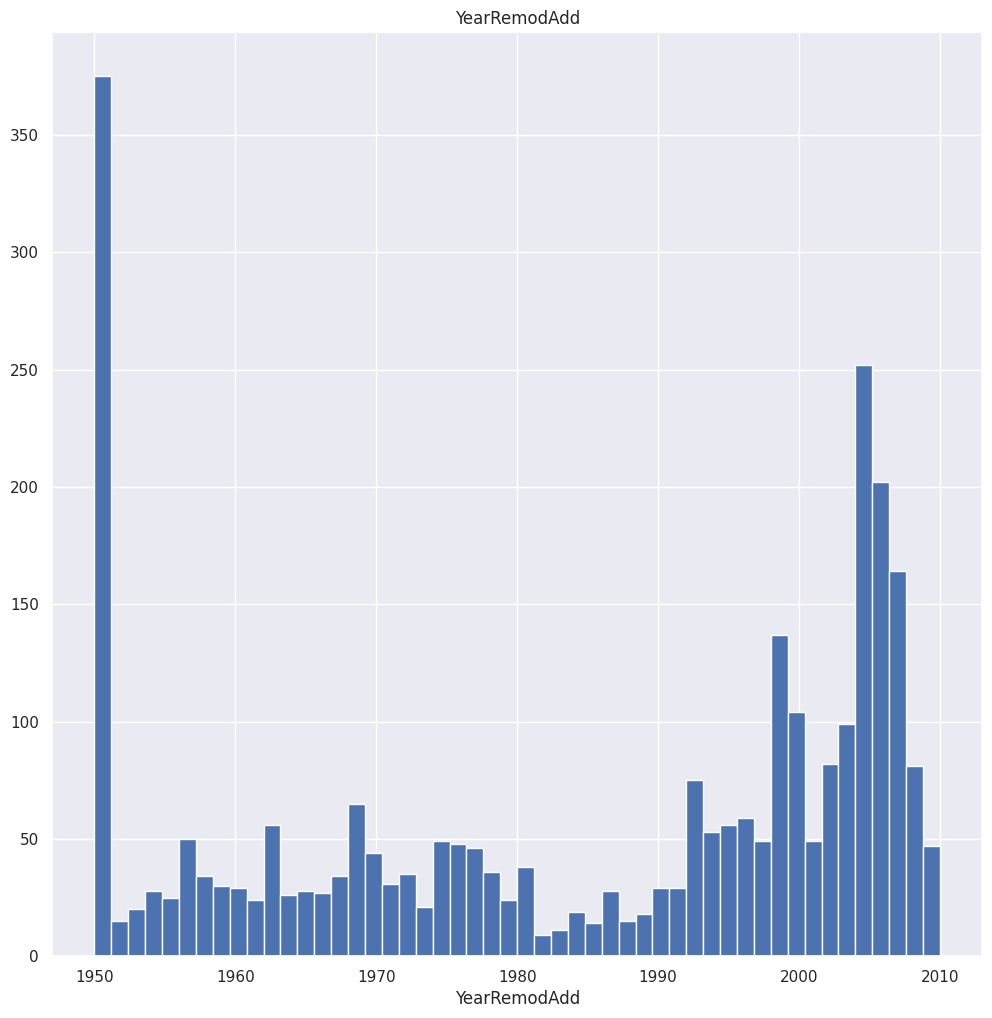

#####################################
count   2896.000
mean     102.201
std      179.334
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%      120.000
80%      202.000
90%      325.500
95%      466.500
99%      771.050
max     1600.000
Name: MasVnrArea, dtype: float64


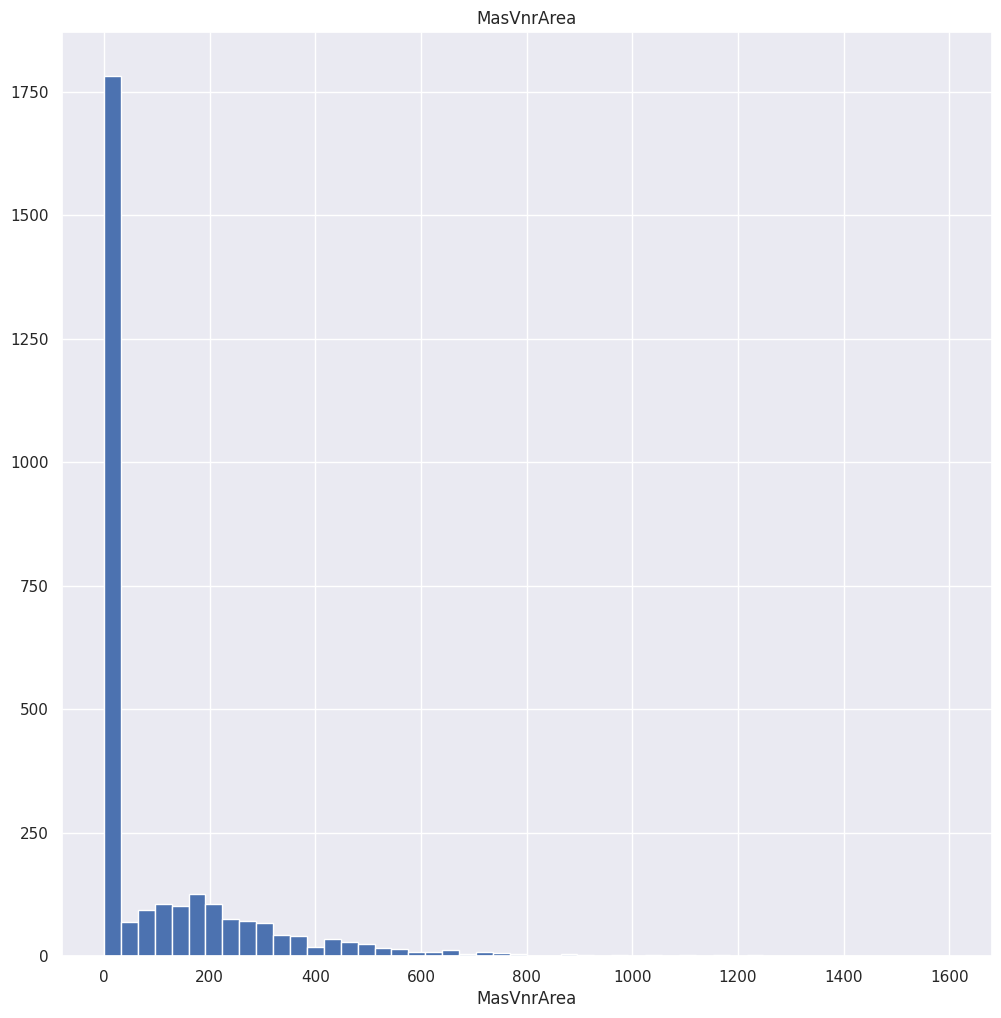

#####################################
count   2918.000
mean     441.423
std      455.611
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%      202.600
50%      368.500
60%      515.200
70%      656.000
80%      812.000
90%     1056.900
95%     1274.000
99%     1635.320
max     5644.000
Name: BsmtFinSF1, dtype: float64


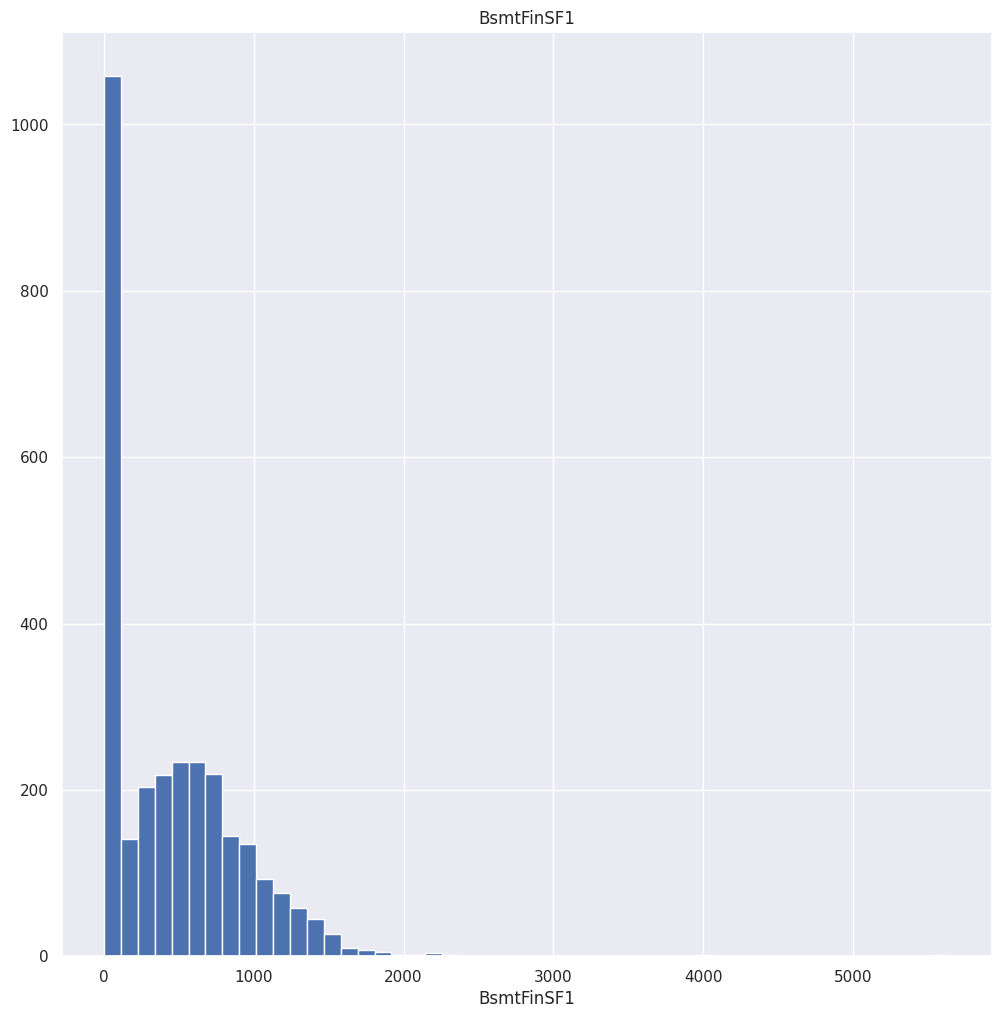

#####################################
count   2918.000
mean      49.582
std      169.206
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%      125.600
95%      435.000
99%      874.660
max     1526.000
Name: BsmtFinSF2, dtype: float64


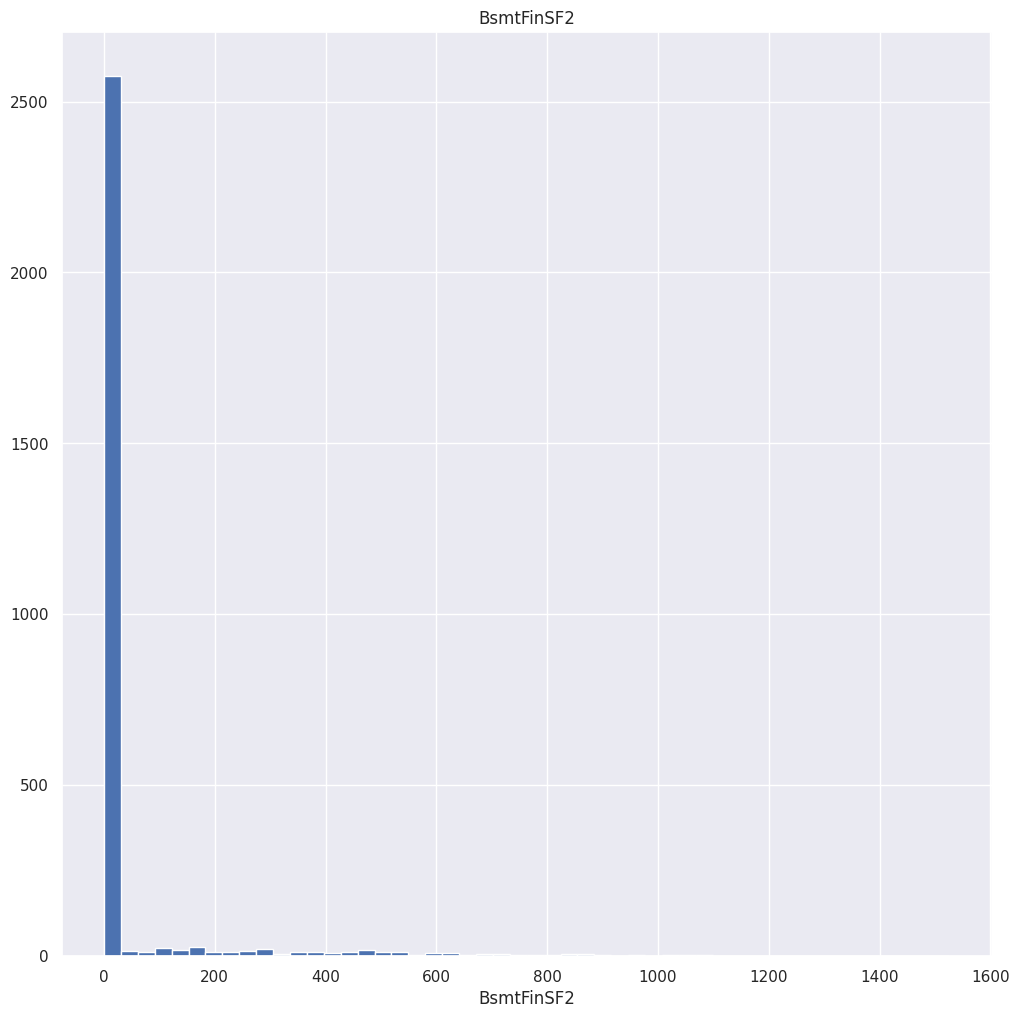

#####################################
count   2918.000
mean     560.772
std      439.544
min        0.000
5%         0.000
10%       56.000
20%      174.000
30%      270.000
40%      365.800
50%      467.000
60%      595.000
70%      732.000
80%      892.600
90%     1212.600
95%     1474.900
99%     1776.490
max     2336.000
Name: BsmtUnfSF, dtype: float64


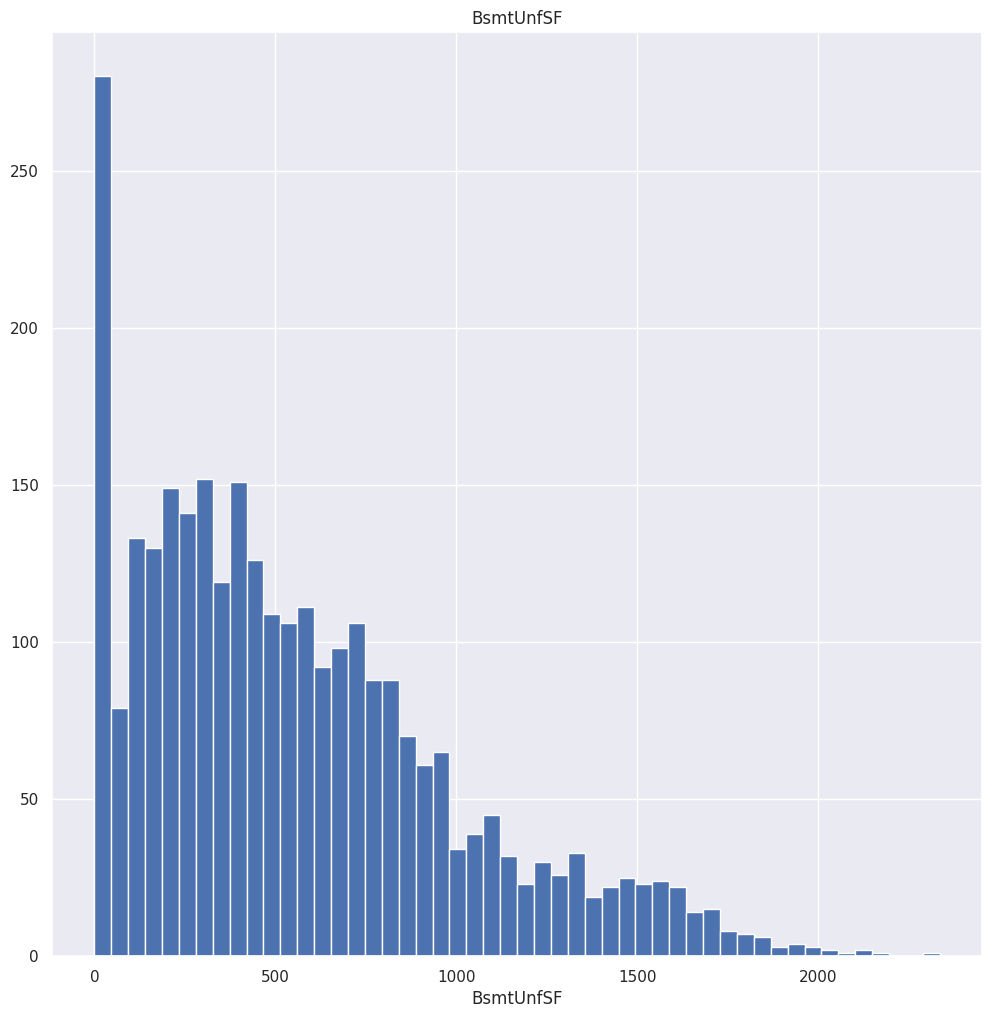

#####################################
count   2918.000
mean    1051.778
std      440.766
min        0.000
5%       455.250
10%      600.000
20%      741.000
30%      836.000
40%      911.000
50%      989.500
60%     1089.200
70%     1216.000
80%     1392.000
90%     1614.000
95%     1776.150
99%     2198.300
max     6110.000
Name: TotalBsmtSF, dtype: float64


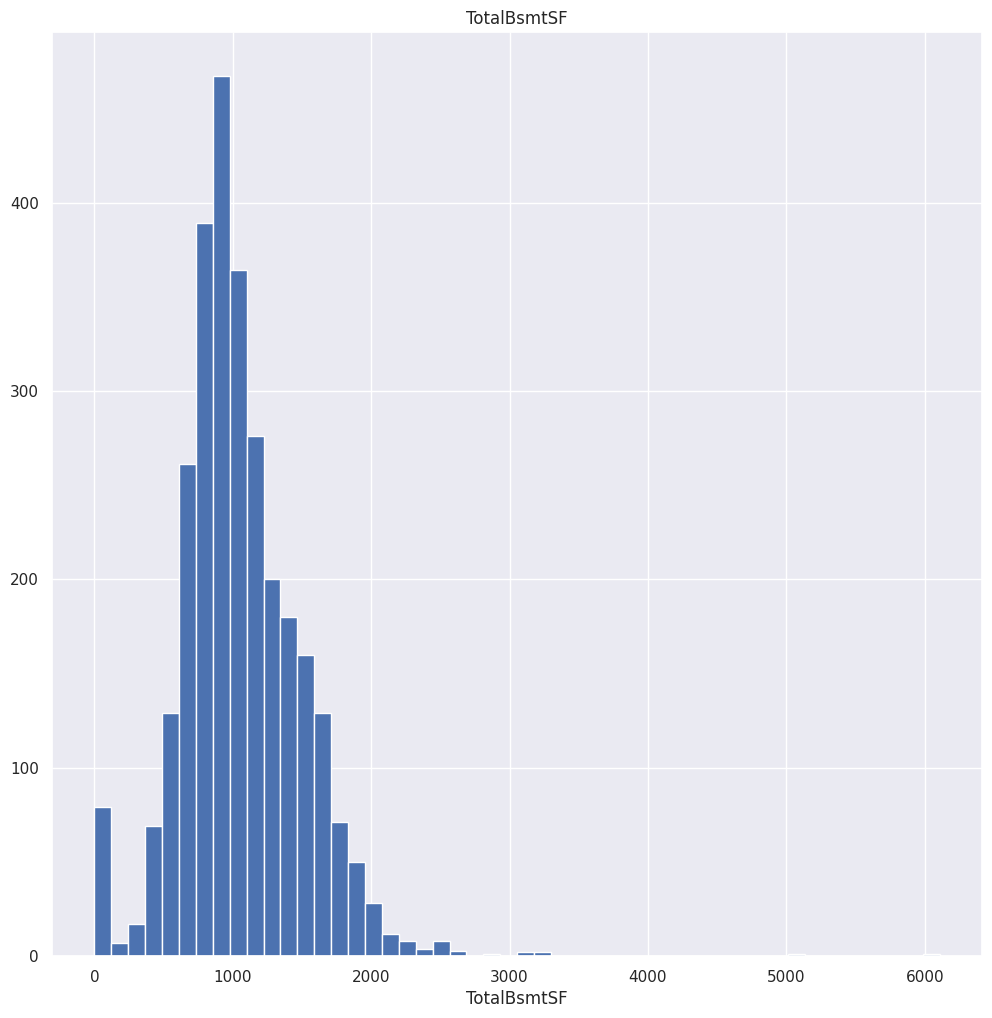

#####################################
count   2919.000
mean    1159.582
std      392.362
min      334.000
5%       665.900
10%      744.800
20%      847.000
30%      914.000
40%      996.200
50%     1082.000
60%     1180.000
70%     1314.000
80%     1483.400
90%     1675.000
95%     1830.100
99%     2288.020
max     5095.000
Name: 1stFlrSF, dtype: float64


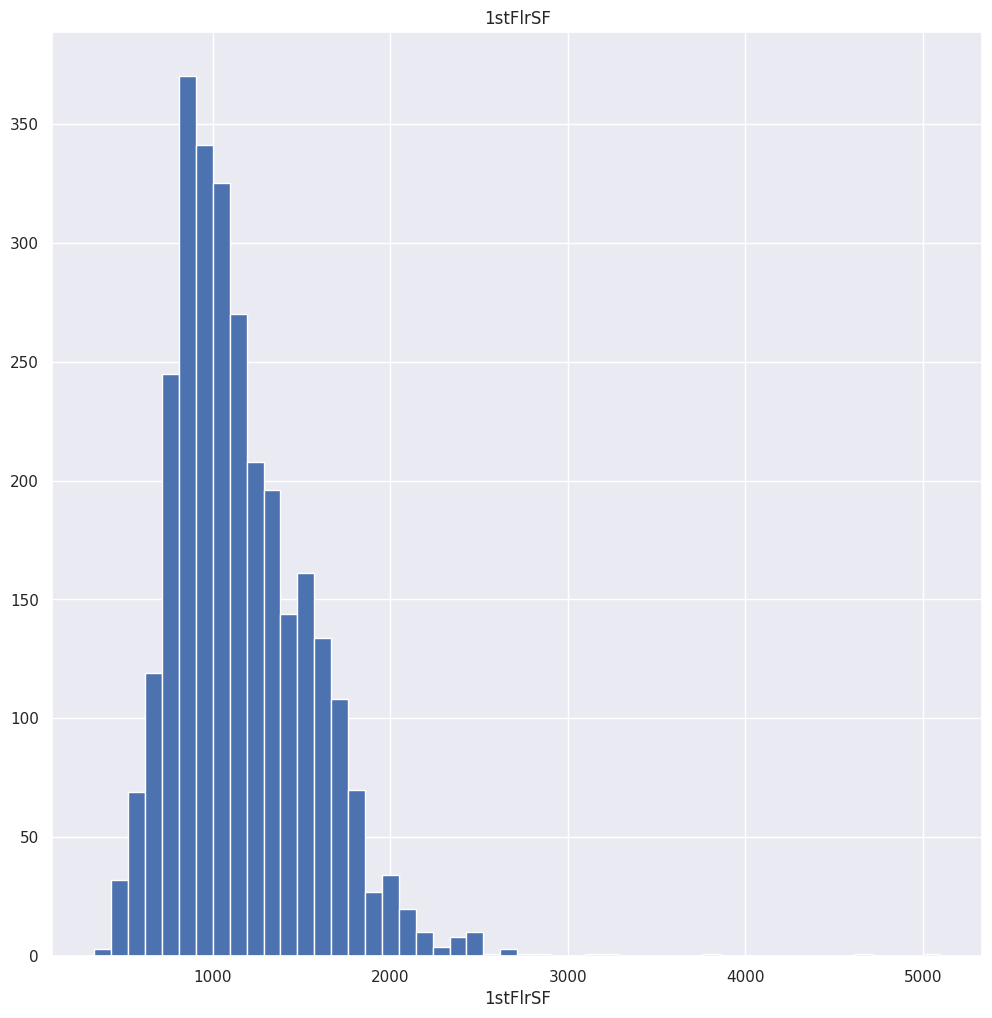

#####################################
count   2919.000
mean     336.484
std      428.701
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%      427.400
70%      636.000
80%      770.800
90%      925.000
95%     1131.200
99%     1400.200
max     2065.000
Name: 2ndFlrSF, dtype: float64


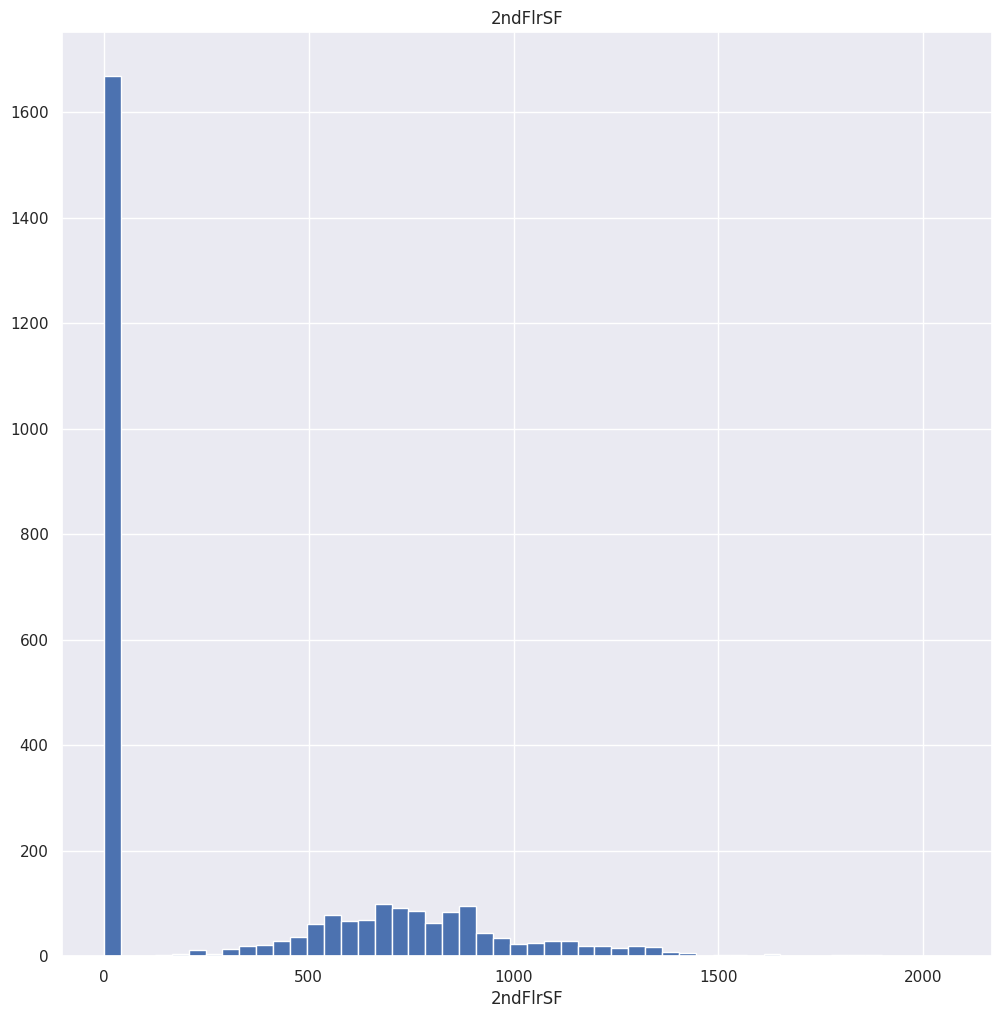

#####################################
count   2919.000
mean       4.694
std       46.397
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%        0.000
99%      153.840
max     1064.000
Name: LowQualFinSF, dtype: float64


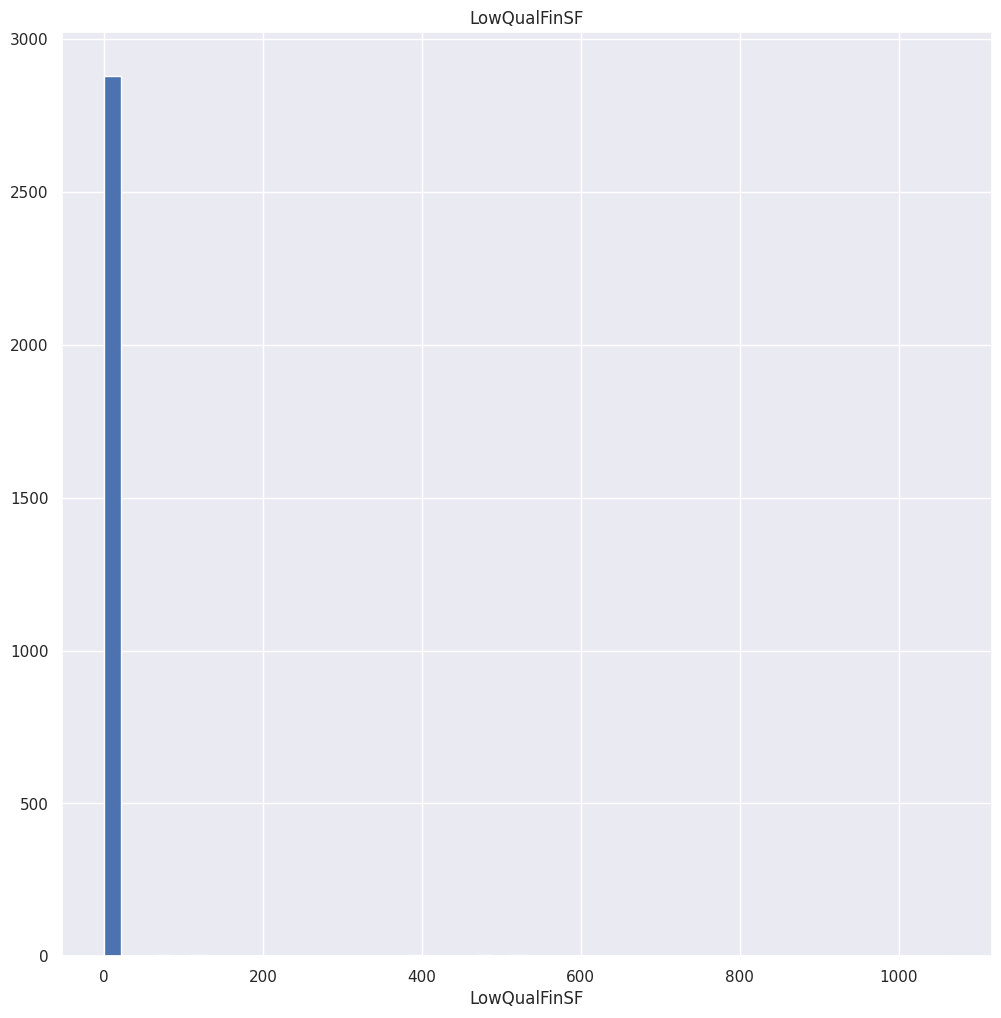

#####################################
count   2919.000
mean    1500.760
std      506.051
min      334.000
5%       861.000
10%      923.800
20%     1064.600
30%     1200.000
40%     1329.200
50%     1444.000
60%     1560.000
70%     1680.000
80%     1838.400
90%     2153.200
95%     2464.200
99%     2935.720
max     5642.000
Name: GrLivArea, dtype: float64


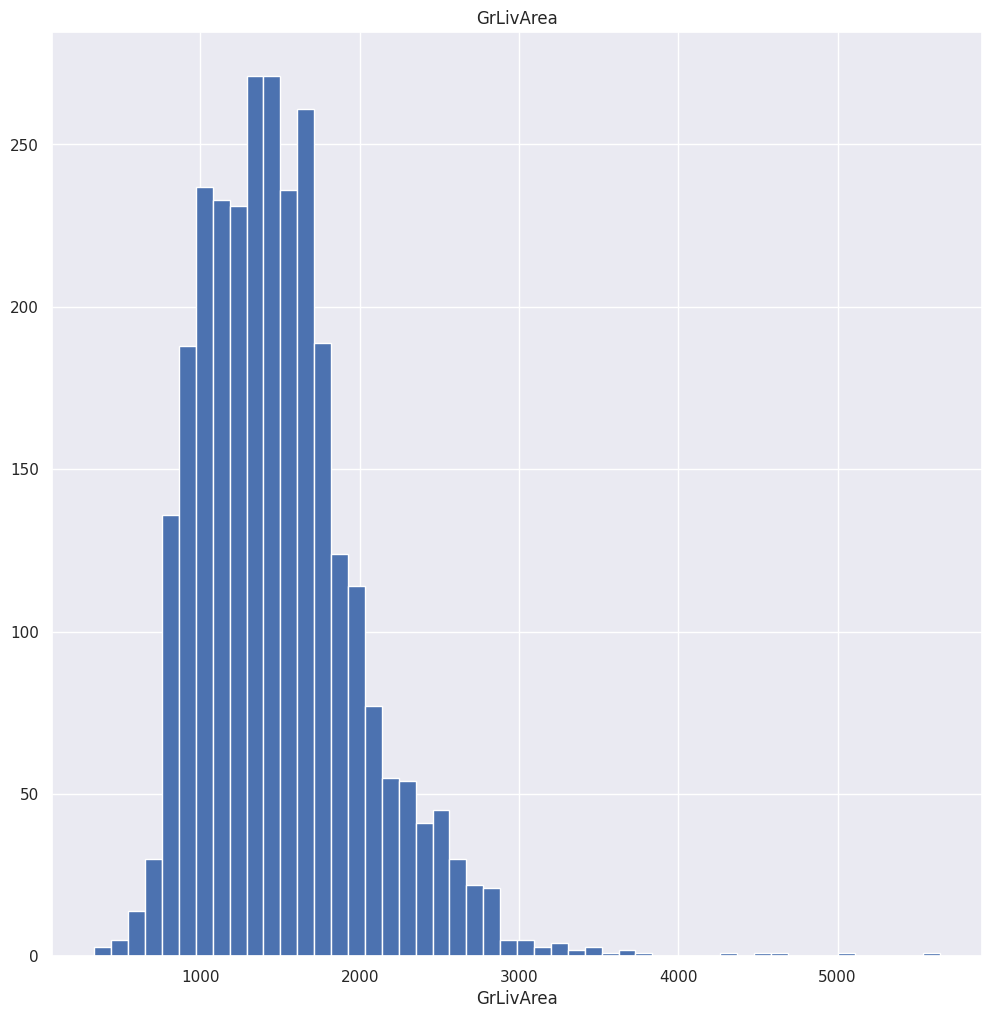

#####################################
count   2919.000
mean       6.452
std        1.569
min        2.000
5%         4.000
10%        5.000
20%        5.000
30%        6.000
40%        6.000
50%        6.000
60%        7.000
70%        7.000
80%        8.000
90%        8.000
95%        9.000
99%       11.000
max       15.000
Name: TotRmsAbvGrd, dtype: float64


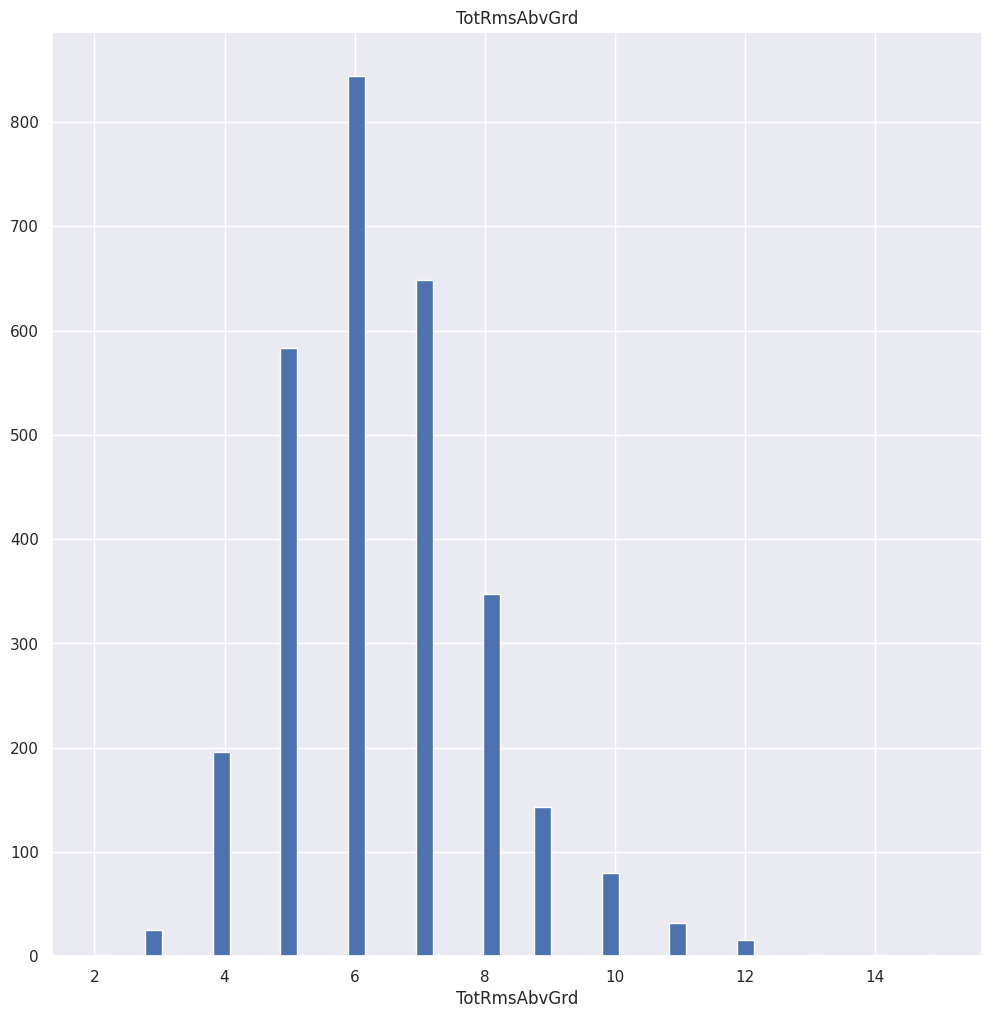

#####################################
count   2760.000
mean    1978.113
std       25.574
min     1895.000
5%      1928.000
10%     1941.000
20%     1957.000
30%     1964.000
40%     1972.000
50%     1979.000
60%     1993.000
70%     1999.000
80%     2004.000
90%     2006.000
95%     2007.000
99%     2009.000
max     2207.000
Name: GarageYrBlt, dtype: float64


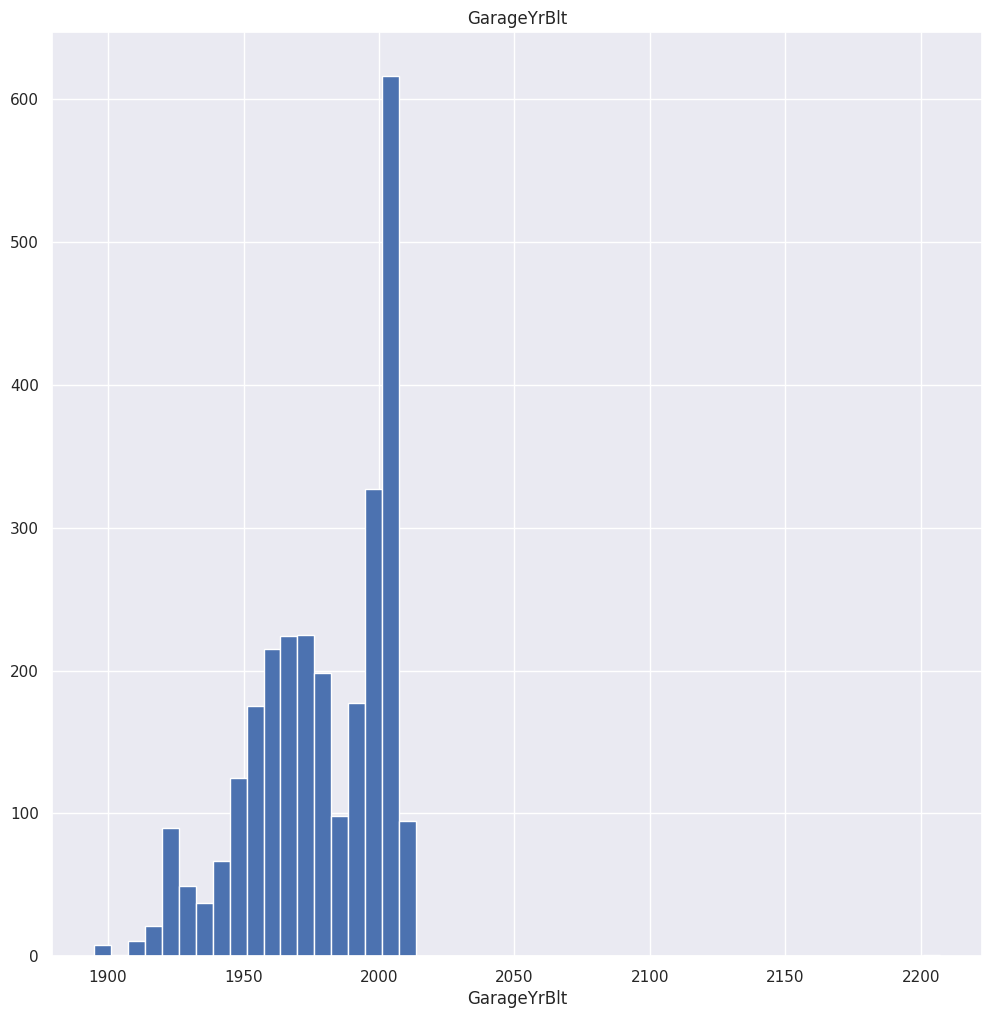

#####################################
count   2918.000
mean     472.875
std      215.395
min        0.000
5%         0.000
10%      240.000
20%      296.000
30%      379.000
40%      440.000
50%      480.000
60%      513.000
70%      560.900
80%      621.000
90%      758.000
95%      856.150
99%     1019.490
max     1488.000
Name: GarageArea, dtype: float64


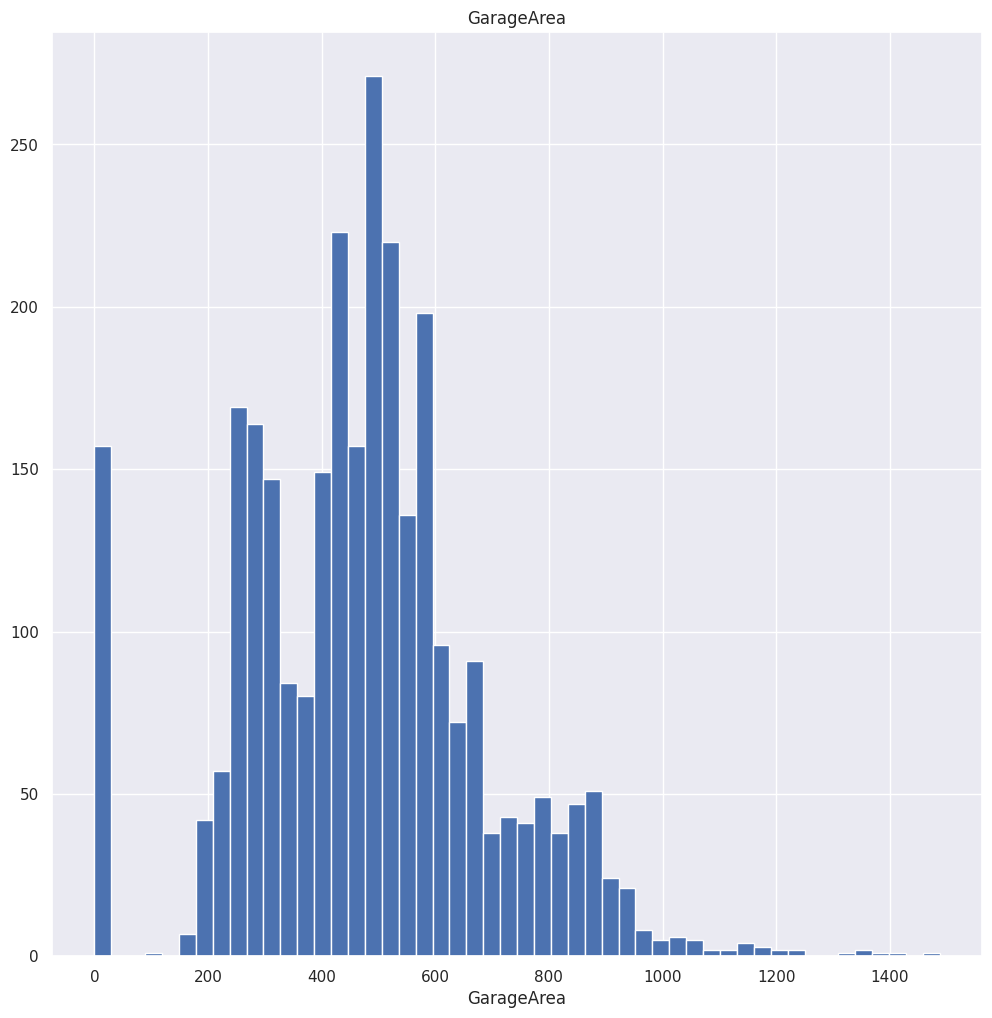

#####################################
count   2919.000
mean      93.710
std      126.527
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%      100.000
70%      144.000
80%      192.000
90%      257.000
95%      328.000
99%      500.820
max     1424.000
Name: WoodDeckSF, dtype: float64


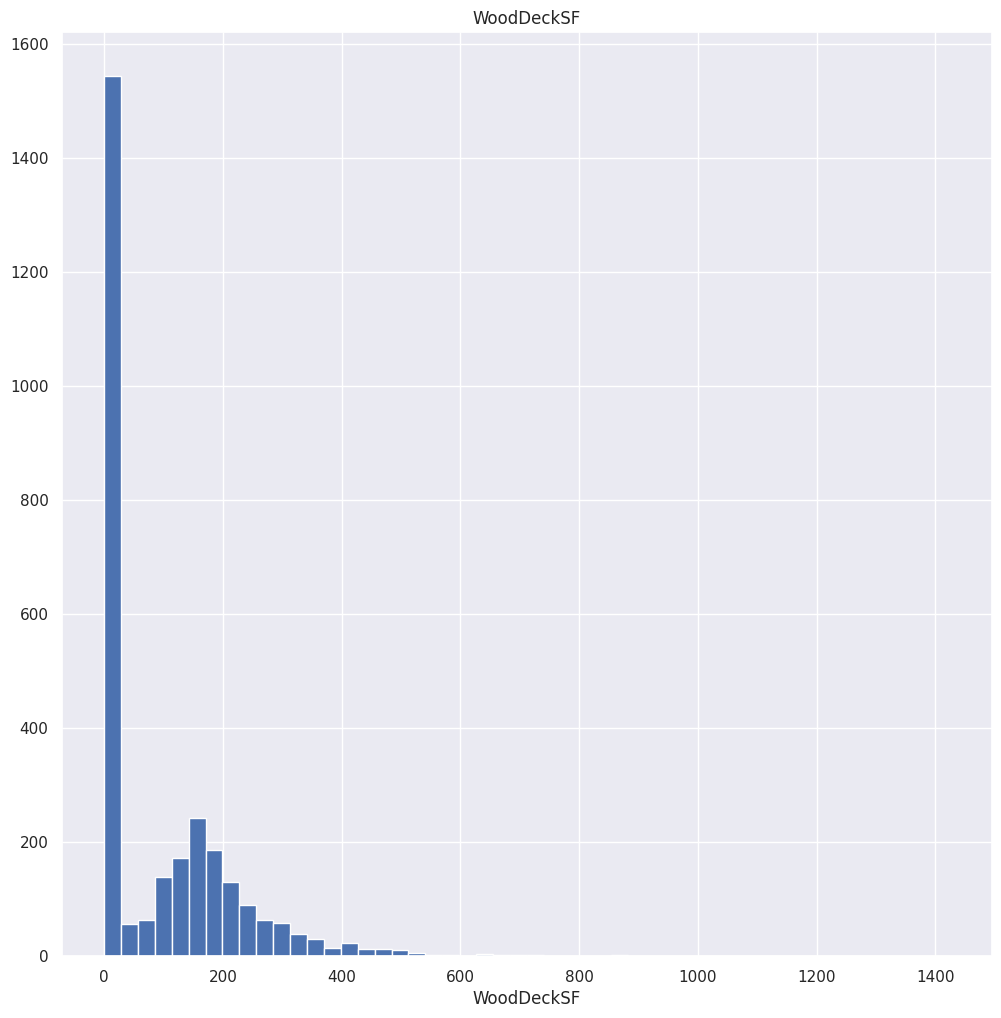

#####################################
count   2919.000
mean      47.487
std       67.575
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%       26.000
60%       40.000
70%       58.000
80%       85.000
90%      131.200
95%      183.100
99%      284.460
max      742.000
Name: OpenPorchSF, dtype: float64


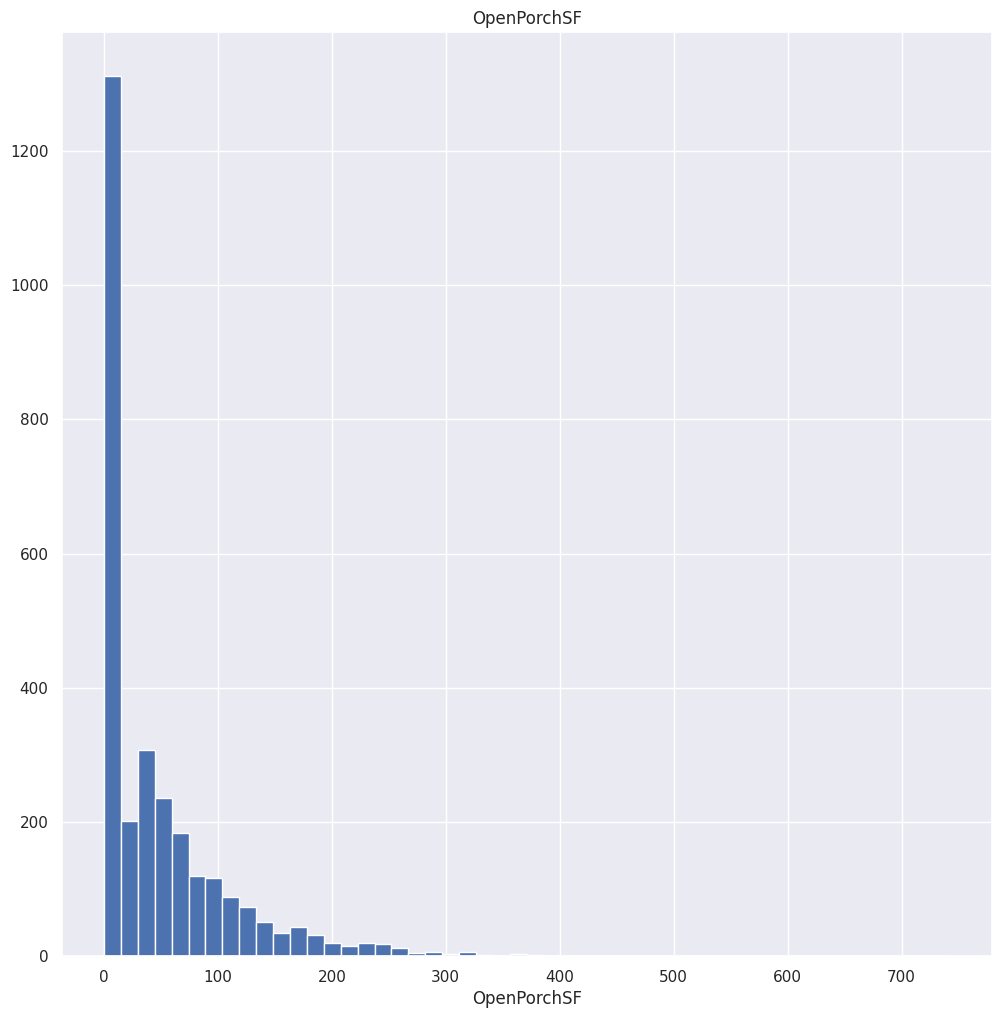

#####################################
count   2919.000
mean      23.098
std       64.244
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%      112.000
95%      176.000
99%      264.000
max     1012.000
Name: EnclosedPorch, dtype: float64


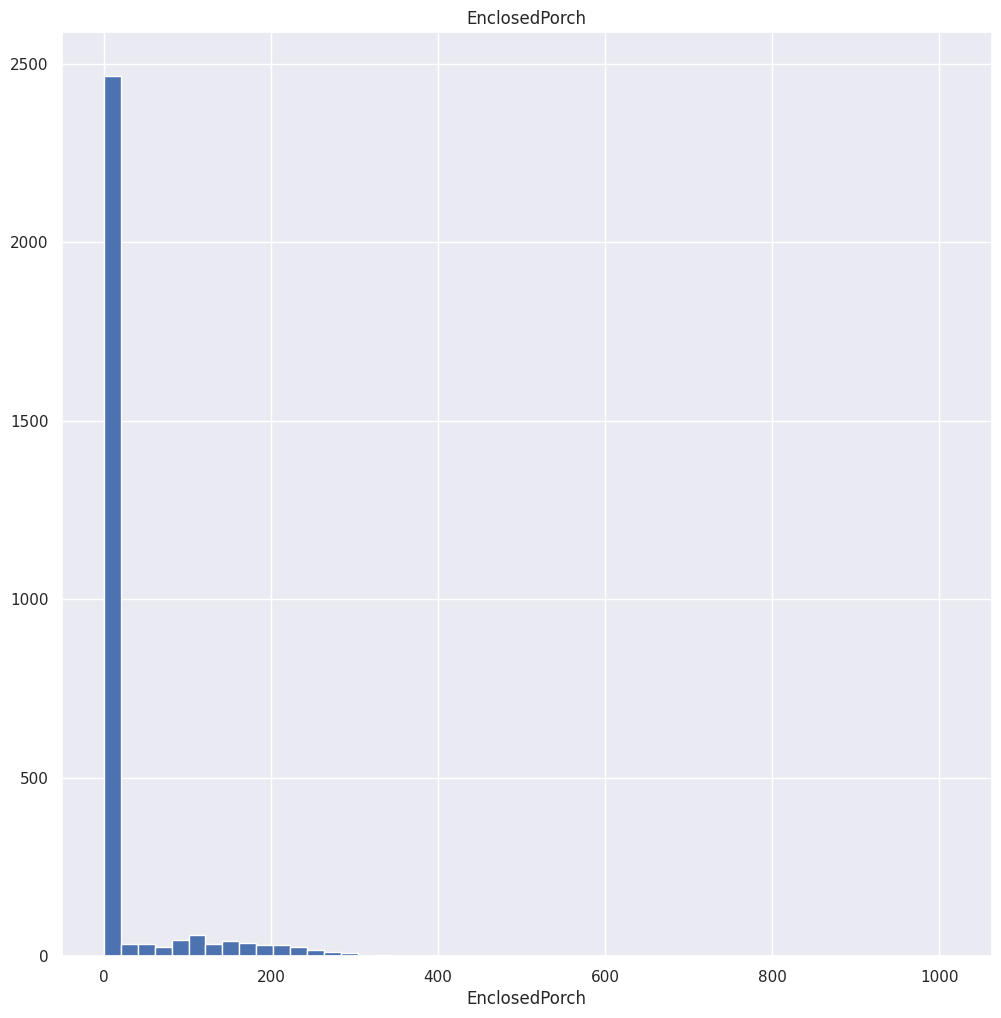

#####################################
count   2919.000
mean       2.602
std       25.188
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%        0.000
99%      144.000
max      508.000
Name: 3SsnPorch, dtype: float64


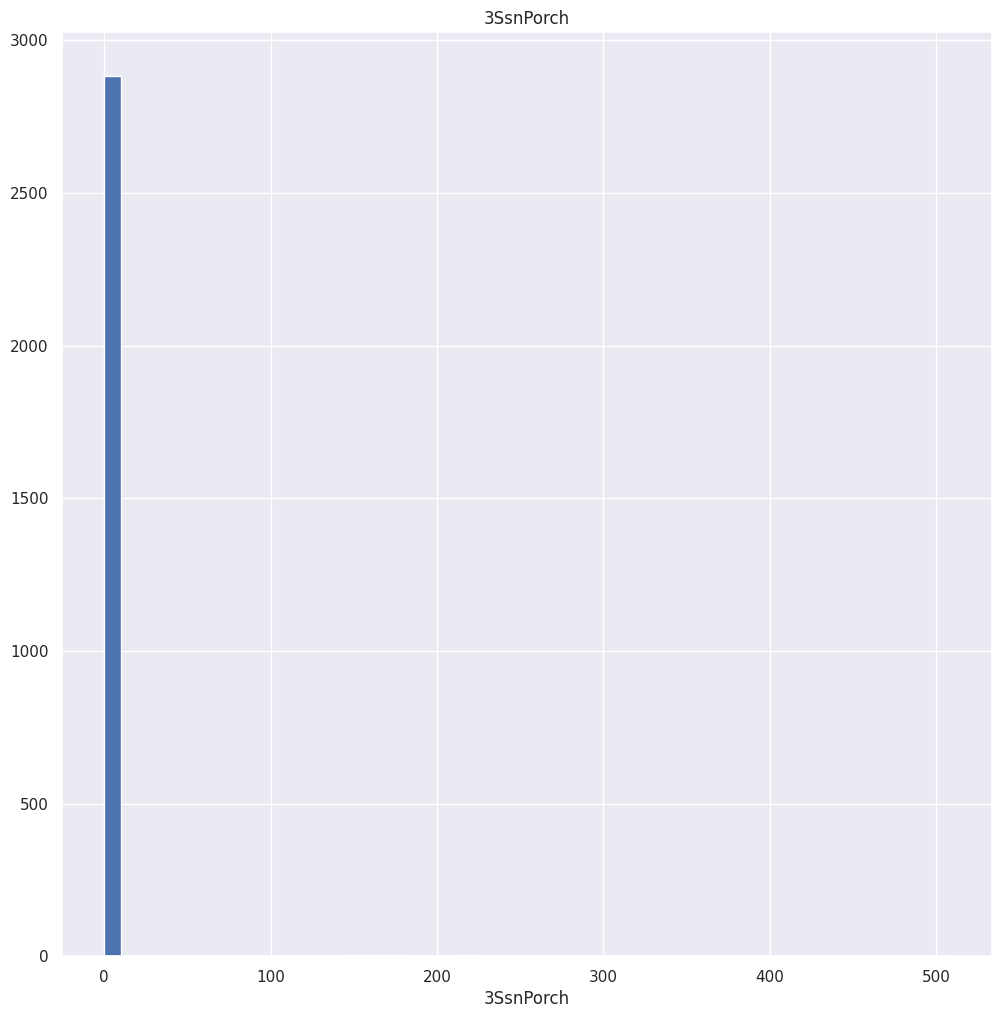

#####################################
count   2919.000
mean      16.062
std       56.184
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%      161.000
99%      259.820
max      576.000
Name: ScreenPorch, dtype: float64


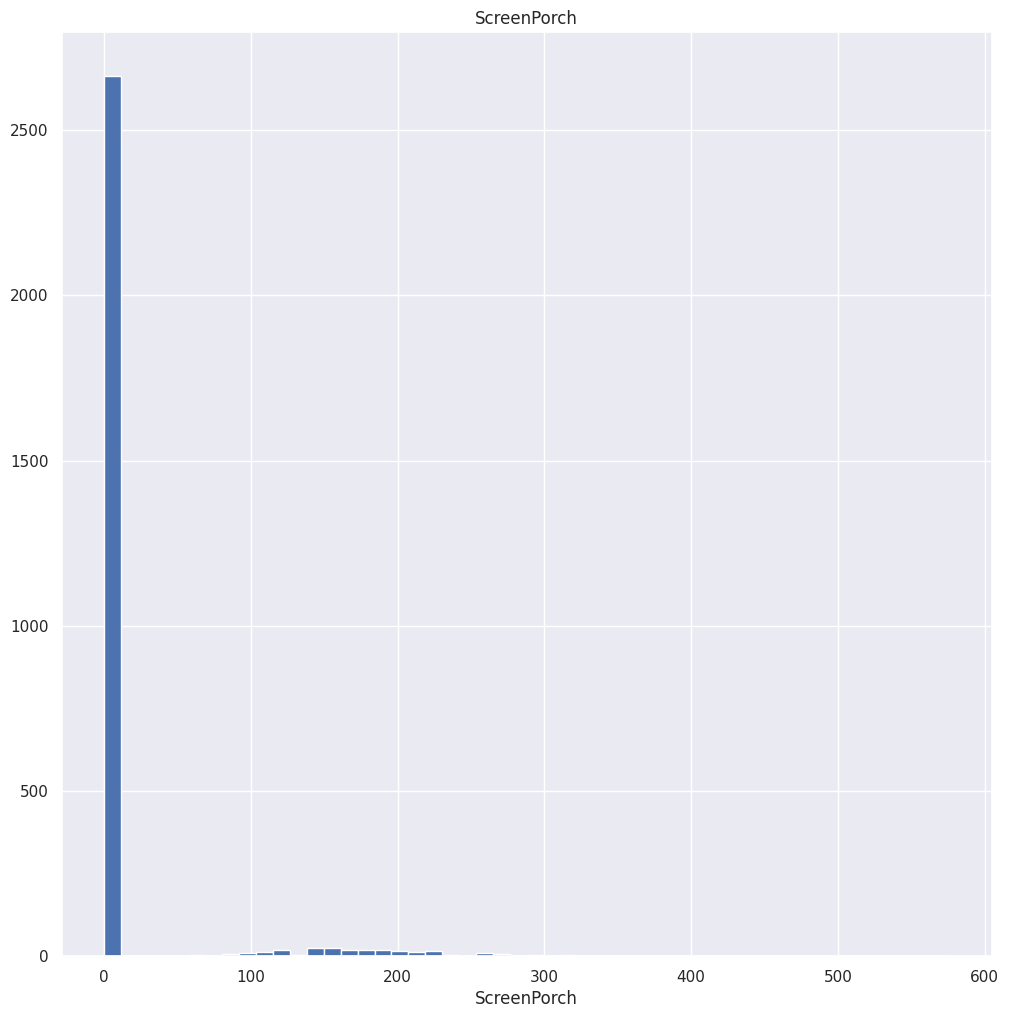

#####################################
count   2919.000
mean       2.252
std       35.664
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%        0.000
99%        0.000
max      800.000
Name: PoolArea, dtype: float64


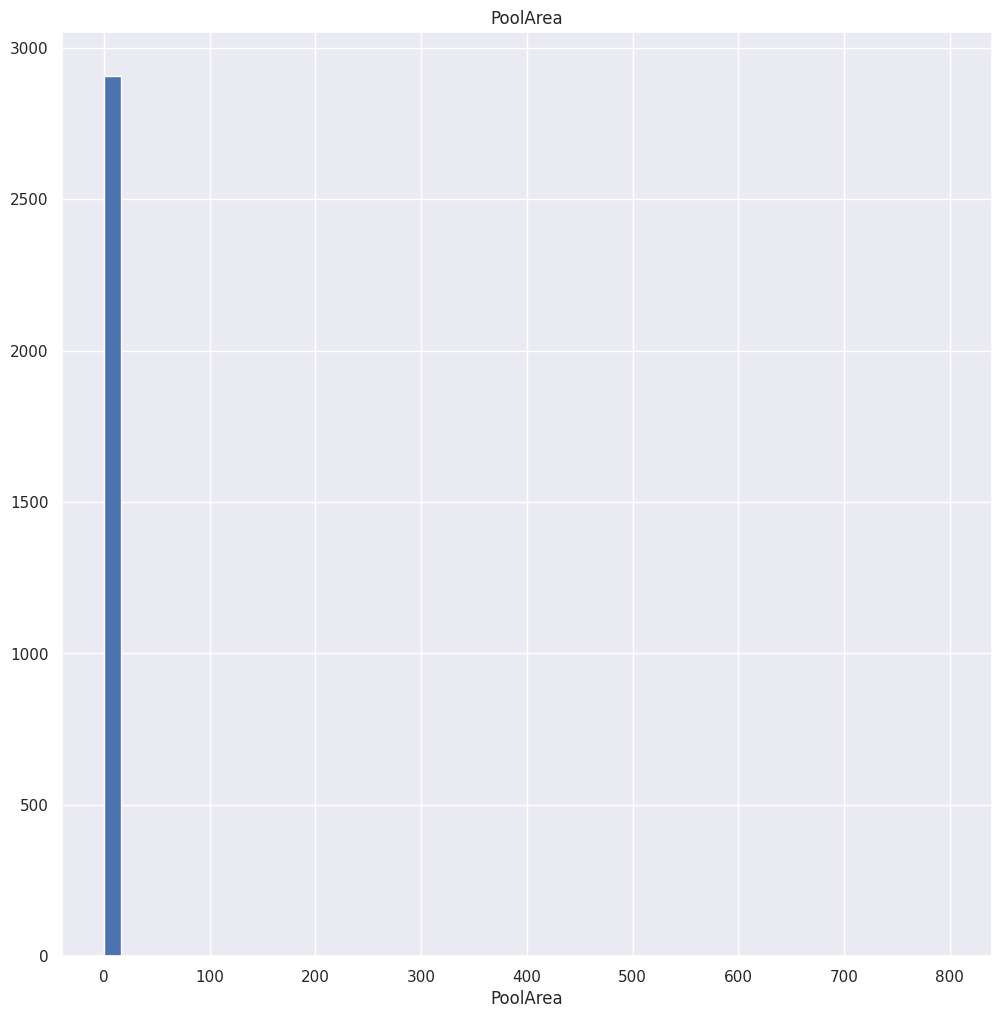

#####################################
count    2919.000
mean       50.826
std       567.402
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         0.000
95%         0.000
99%       982.000
max     17000.000
Name: MiscVal, dtype: float64


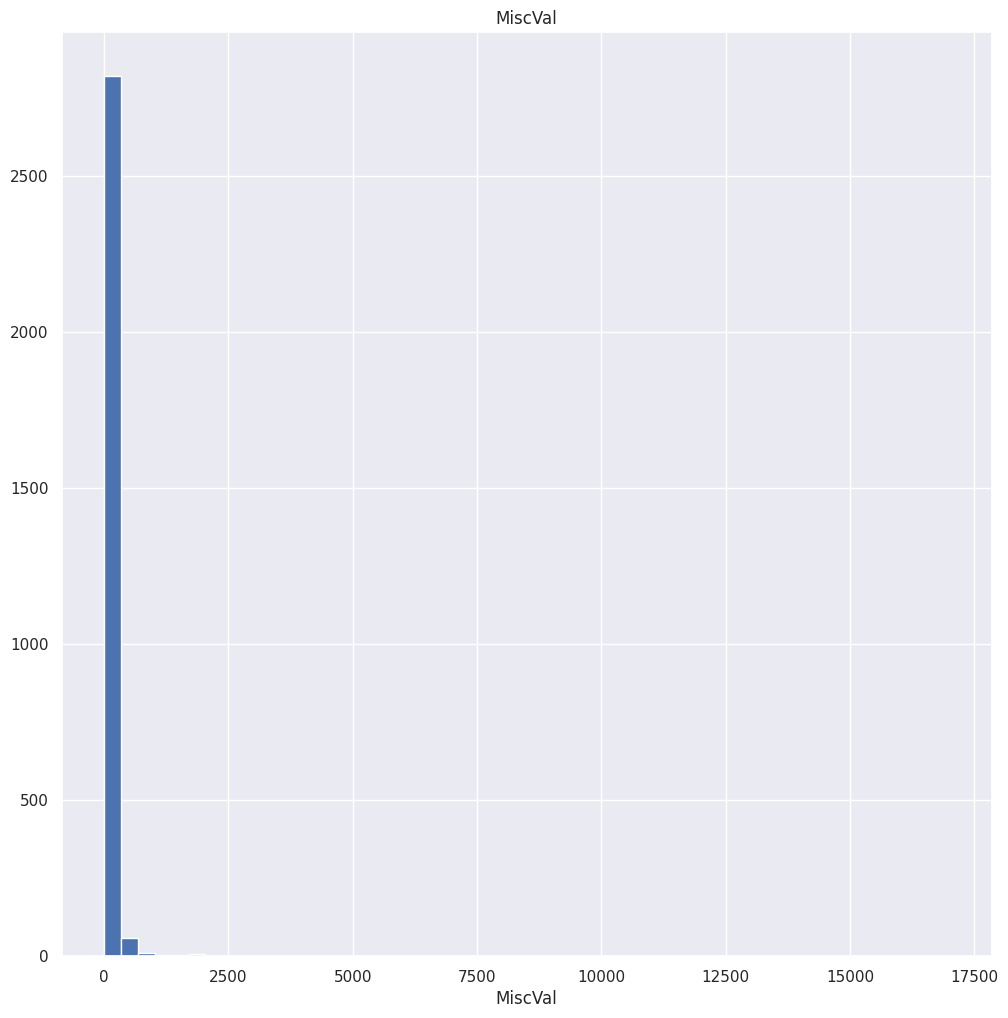

#####################################
count   2919.000
mean       6.213
std        2.715
min        1.000
5%         2.000
10%        3.000
20%        4.000
30%        5.000
40%        6.000
50%        6.000
60%        7.000
70%        7.000
80%        8.000
90%       10.000
95%       11.000
99%       12.000
max       12.000
Name: MoSold, dtype: float64


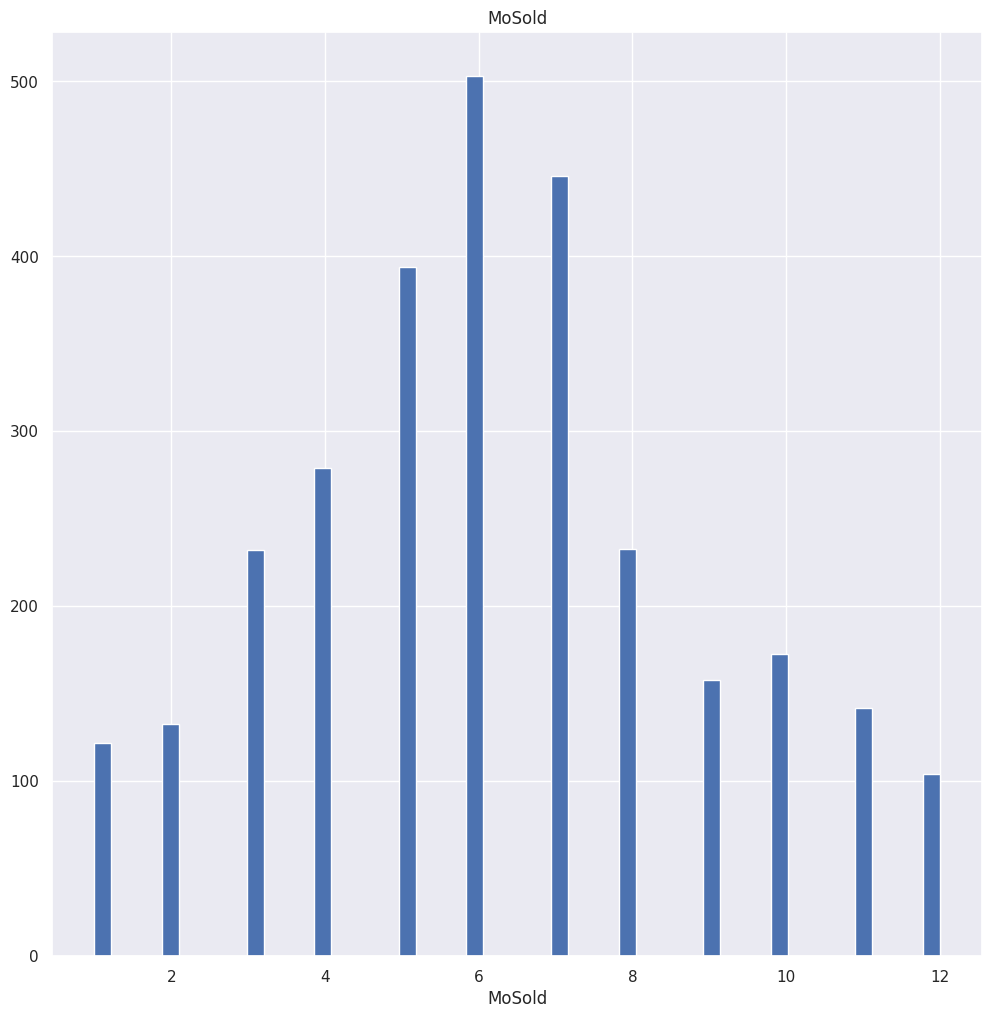

#####################################
count     1460.000
mean    180921.196
std      79442.503
min      34900.000
5%       88000.000
10%     106475.000
20%     124000.000
30%     135500.000
40%     147000.000
50%     163000.000
60%     179280.000
70%     198620.000
80%     230000.000
90%     278000.000
95%     326100.000
99%     442567.010
max     755000.000
Name: SalePrice, dtype: float64


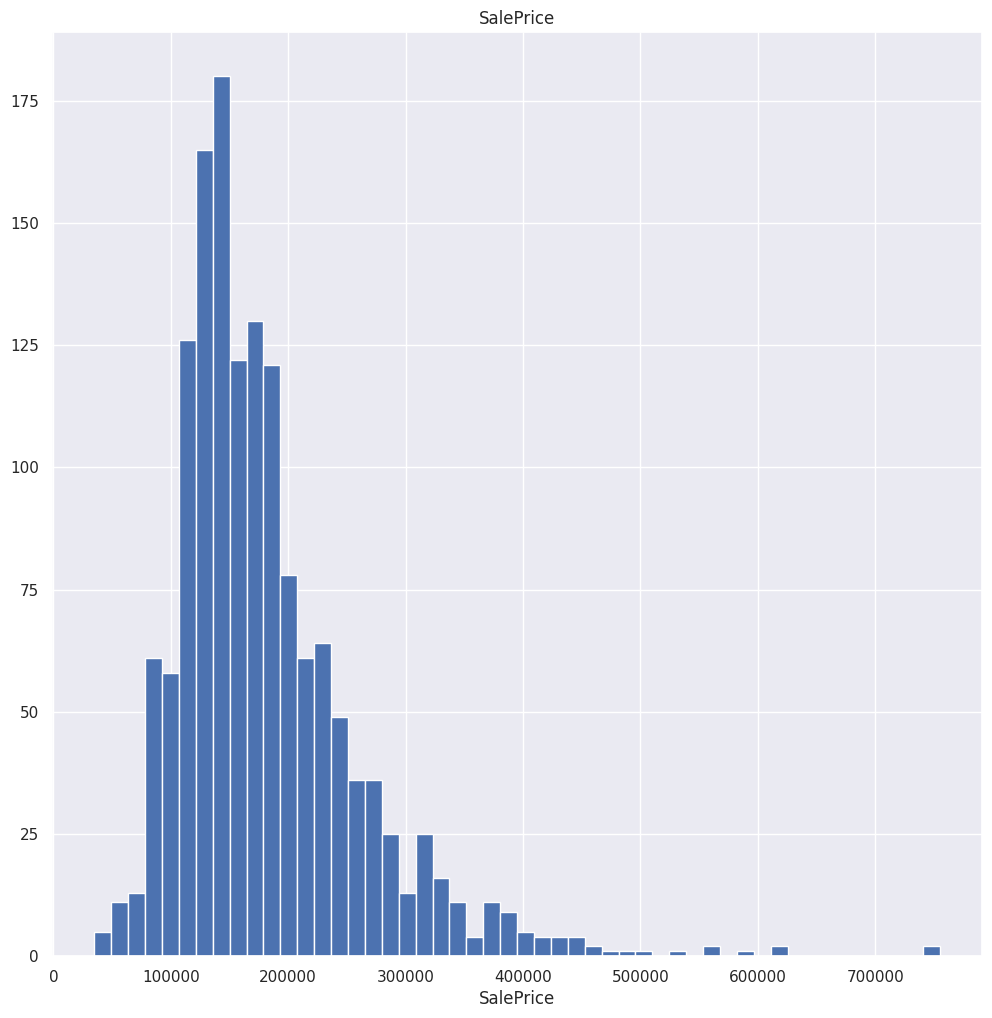

#####################################


In [153]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")


for col in num_cols:
    num_summary(df, col, True)

#### Analysis of Target Variable

          TARGET_MEAN
MSZoning             
C (all)     74528.000
FV         214014.062
RH         131558.375
RL         191004.995
RM         126316.830


        TARGET_MEAN
Street             
Grvl     130190.500
Pave     181130.539


       TARGET_MEAN
Alley             
Grvl    122219.080
Pave    168000.585


          TARGET_MEAN
LotShape             
IR1        206101.665
IR2        239833.366
IR3        216036.500
Reg        164754.818


             TARGET_MEAN
LandContour             
Bnk           143104.079
HLS           231533.940
Low           203661.111
Lvl           180183.747


           TARGET_MEAN
Utilities             
AllPub      180950.957
NoSeWa      137500.000


           TARGET_MEAN
LotConfig             
Corner      181623.426
CulDSac     223854.617
FR2         177934.574
FR3         208475.000
Inside      176938.048


           TARGET_MEAN
LandSlope             
Gtl         179956.800
Mod         196734.138
Sev         204379.231


            TARGET_MEAN


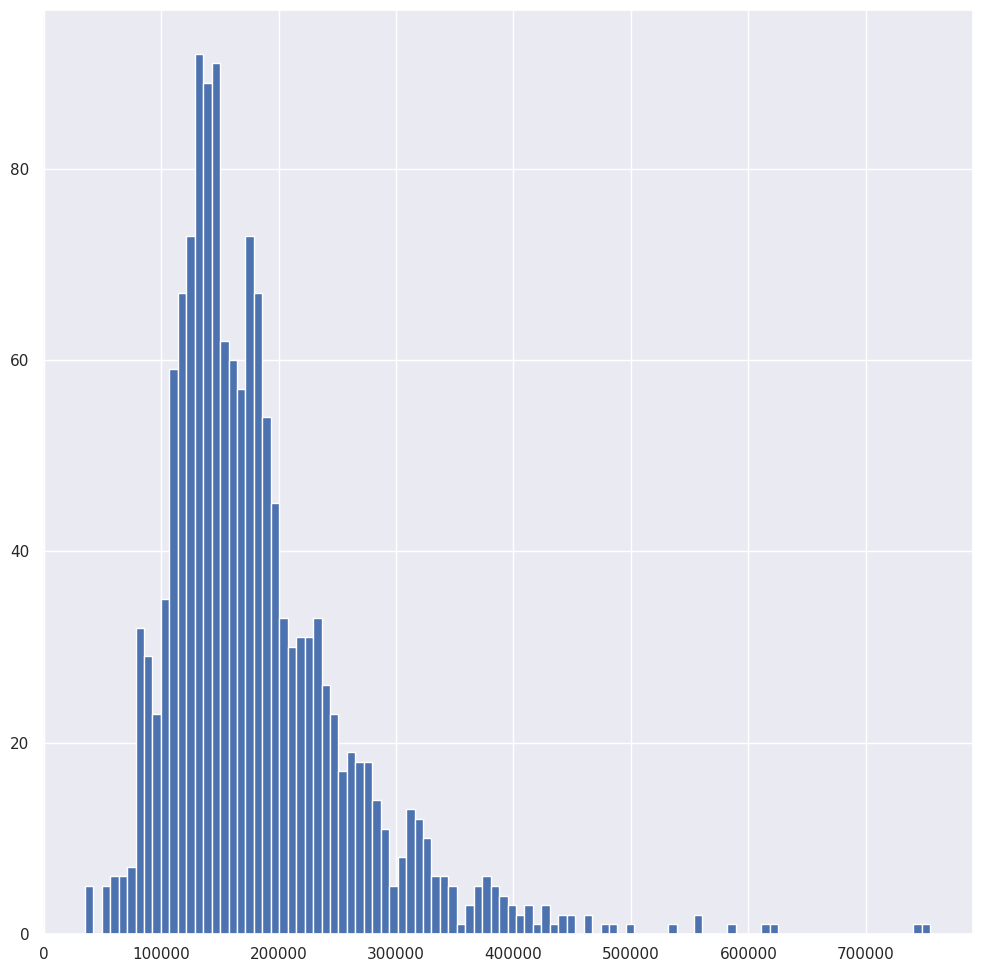

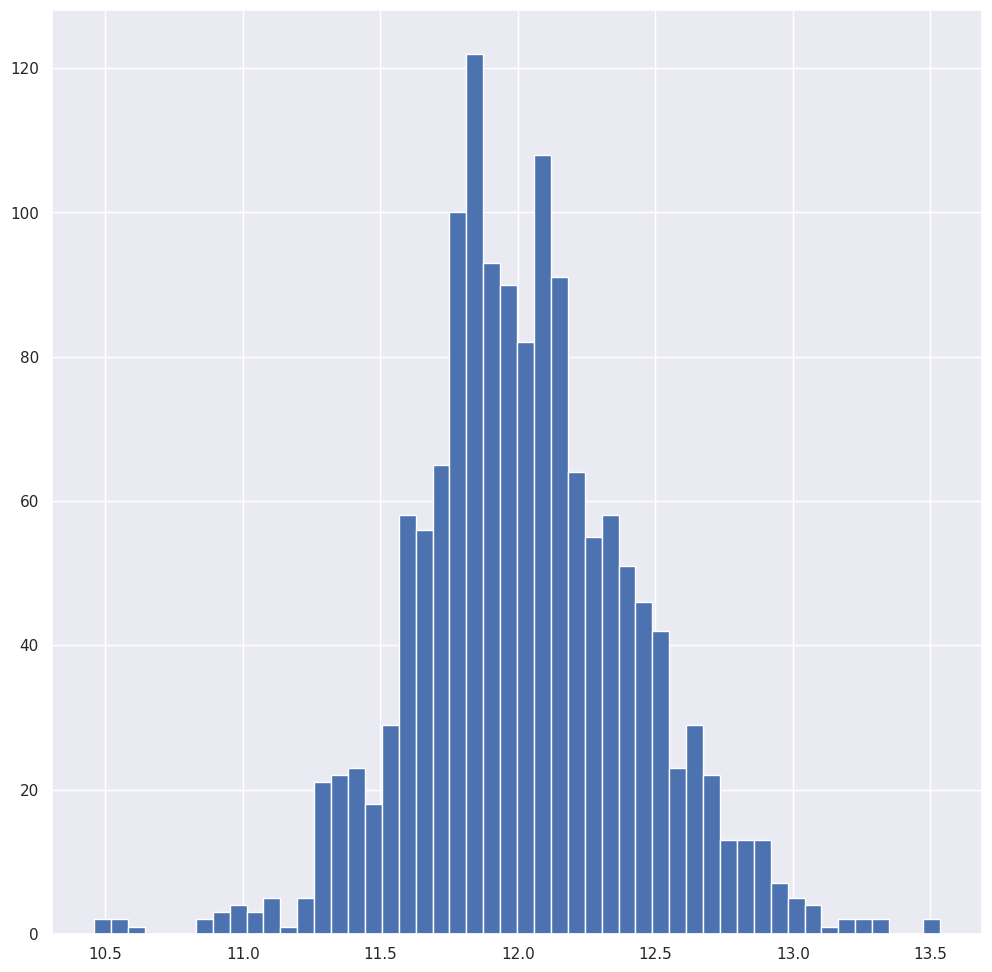

In [155]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


for col in cat_cols:
    target_summary_with_cat(df,"SalePrice",col)


# Examining the dependent variable
df["SalePrice"].hist(bins=100)
plt.show()

# Examining the logarithm of the dependent variable
np.log1p(df['SalePrice']).hist(bins=50)
plt.show()

<a id='3'></a>
### Part 3 :  Feature Engineering

#### Aykırı Değer Analizi

In [10]:
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [11]:
for col in num_cols:
    if col != "SalePrice": # Since it is the dependent variable
      print(col, check_outlier(df, col))

Id False
MSSubClass False
LotFrontage True
LotArea True
OverallQual False
YearBuilt False
YearRemodAdd False
MasVnrArea True
BsmtFinSF1 True
BsmtFinSF2 True
BsmtUnfSF False
TotalBsmtSF True
1stFlrSF True
2ndFlrSF False
LowQualFinSF True
GrLivArea True
TotRmsAbvGrd True
GarageYrBlt True
GarageArea False
WoodDeckSF True
OpenPorchSF True
EnclosedPorch True
3SsnPorch True
ScreenPorch True
PoolArea True
MiscVal True
MoSold False


In [158]:
for col in num_cols:
    if col != "SalePrice":
        replace_with_thresholds(df,col)

#### Missing Value Analysis 

In [12]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns

missing_values_table(df)

              n_miss  ratio
PoolQC          2909 99.660
MiscFeature     2814 96.400
Alley           2721 93.220
Fence           2348 80.440
MasVnrType      1766 60.500
SalePrice       1459 49.980
FireplaceQu     1420 48.650
LotFrontage      486 16.650
GarageCond       159  5.450
GarageYrBlt      159  5.450
GarageFinish     159  5.450
GarageQual       159  5.450
GarageType       157  5.380
BsmtExposure      82  2.810
BsmtCond          82  2.810
BsmtQual          81  2.770
BsmtFinType2      80  2.740
BsmtFinType1      79  2.710
MasVnrArea        23  0.790
MSZoning           4  0.140
Functional         2  0.070
BsmtHalfBath       2  0.070
BsmtFullBath       2  0.070
Utilities          2  0.070
KitchenQual        1  0.030
TotalBsmtSF        1  0.030
BsmtUnfSF          1  0.030
GarageCars         1  0.030
GarageArea         1  0.030
BsmtFinSF2         1  0.030
BsmtFinSF1         1  0.030
Exterior2nd        1  0.030
Exterior1st        1  0.030
SaleType           1  0.030
Electrical         1

Null values in some variables indicate that the house does not have that feature.

In [13]:
no_cols = ["Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu",
           "GarageType","GarageFinish","GarageQual","GarageCond","PoolQC","Fence","MiscFeature"]


for col in no_cols:
    df[col].fillna("No",inplace=True)

missing_values_table(df)

              n_miss  ratio
MasVnrType      1766 60.500
SalePrice       1459 49.980
LotFrontage      486 16.650
GarageYrBlt      159  5.450
MasVnrArea        23  0.790
MSZoning           4  0.140
BsmtFullBath       2  0.070
BsmtHalfBath       2  0.070
Functional         2  0.070
Utilities          2  0.070
Exterior2nd        1  0.030
BsmtFinSF1         1  0.030
BsmtFinSF2         1  0.030
BsmtUnfSF          1  0.030
Exterior1st        1  0.030
Electrical         1  0.030
KitchenQual        1  0.030
GarageCars         1  0.030
GarageArea         1  0.030
SaleType           1  0.030
TotalBsmtSF        1  0.030


This function fills in missing values with median or mean.

In [14]:
def quick_missing_imp(data, num_method="median", cat_length=20, target="SalePrice"):
    variables_with_na = [col for col in data.columns if data[col].isnull().sum() > 0]  # Variables with missing values are listed

    temp_target = data[target]

    print("# BEFORE")
    print(data[variables_with_na].isnull().sum(), "\n\n")  # Number of missing values of variables before application

    # If the number of variable objects and classes is equal to or less than cat_length, fill empty values with mode
    data = data.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x, axis=0)

    # If num_method is mean, empty values of variables whose type is not object are filled with the mean.
    if num_method == "mean":
        data = data.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
    # If num_method is median, empty values of variables whose type is not object are filled with the mean.
    elif num_method == "median":
        data = data.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

    data[target] = temp_target

    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(data[variables_with_na].isnull().sum(), "\n\n")

    return data




In [15]:
df = quick_missing_imp(df, num_method="median", cat_length=17)

# BEFORE
MSZoning           4
LotFrontage      486
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType      1766
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
GarageYrBlt      159
GarageCars         1
GarageArea         1
SaleType           1
SalePrice       1459
dtype: int64 


# AFTER 
 Imputation method is 'MODE' for categorical variables!
 Imputation method is 'MEDIAN' for numeric variables! 

MSZoning           0
LotFrontage        0
Utilities          0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea         0
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Electrical         0
BsmtFullBath       0
BsmtHalfBath       0
KitchenQual        0
Functional         0
GarageYrBlt        0
GarageCars         0
GarageArea         0
SaleType      

#### Perform rare analysis and apply rare encoder.

In [16]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")


In [17]:
rare_analyser(df, "SalePrice", cat_cols)

MSZoning : 5
          COUNT  RATIO  TARGET_MEAN
MSZoning                           
C (all)      25  0.009    74528.000
FV          139  0.048   214014.062
RH           26  0.009   131558.375
RL         2269  0.777   191004.995
RM          460  0.158   126316.830


Street : 2
        COUNT  RATIO  TARGET_MEAN
Street                           
Grvl       12  0.004   130190.500
Pave     2907  0.996   181130.539


Alley : 3
       COUNT  RATIO  TARGET_MEAN
Alley                           
Grvl     120  0.041   122219.080
No      2721  0.932   183452.131
Pave      78  0.027   168000.585


LotShape : 4
          COUNT  RATIO  TARGET_MEAN
LotShape                           
IR1         968  0.332   206101.665
IR2          76  0.026   239833.366
IR3          16  0.005   216036.500
Reg        1859  0.637   164754.818


LandContour : 4
             COUNT  RATIO  TARGET_MEAN
LandContour                           
Bnk            117  0.040   143104.079
HLS            120  0.041   231533.940
Low 

Detection of rare classes

In [18]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df


In [19]:
rare_encoder(df,0.01)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL       65.000     8450   Pave    No      Reg   
1        2          20       RL       80.000     9600   Pave    No      Reg   
2        3          60       RL       68.000    11250   Pave    No      IR1   
3        4          70       RL       60.000     9550   Pave    No      IR1   
4        5          60       RL       84.000    14260   Pave    No      IR1   
5        6          50       RL       85.000    14115   Pave    No      IR1   
6        7          20       RL       75.000    10084   Pave    No      Reg   
7        8          60       RL       68.000    10382   Pave    No      IR1   
8        9          50       RM       51.000     6120   Pave    No      Reg   
9       10         190       RL       50.000     7420   Pave    No      Reg   
10      11          20       RL       70.000    11200   Pave    No      Reg   
11      12          60       RL       85.000    11924   Pave    No      IR1   
12      13          20       RL       68.000    12968   Pave    No      IR2   
13      14          20       RL       91.000    10652   Pave    No      IR1   
14      15          20       RL       68.000    10920   Pave    No      IR1   
15      16          45       RM       51.000     6120   Pave    No      Reg   
16      17          20       RL       68.000    11241   Pave    No      IR1   
17      18          90       RL       72.000    10791   Pave    No      Reg   
18      19          20       RL       66.000    13695   Pave    No      Reg   
19      20          20       RL       70.000     7560   Pave    No      Reg   
20      21          60       RL      101.000    14215   Pave    No      IR1   
21      22          45       RM       57.000     7449   Pave  Grvl      Reg   
22      23          20       RL       75.000     9742   Pave    No      Reg   
23      24         120       RM       44.000     4224   Pave    No      Reg   
24      25          20       RL       68.000     8246   Pave    No      IR1   
25      26          20       RL      110.000    14230   Pave    No      Reg   
26      27          20       RL       60.000     7200   Pave    No      Reg   
27      28          20       RL       98.000    11478   Pave    No      Reg   
28      29          20       RL       47.000    16321   Pave    No      IR1   
29      30          30       RM       60.000     6324   Pave    No      IR1   
30      31          70     Rare       50.000     8500   Pave  Pave      Reg   
31      32          20       RL       68.000     8544   Pave    No      IR1   
32      33          20       RL       85.000    11049   Pave    No      Reg   
33      34          20       RL       70.000    10552   Pave    No      IR1   
34      35         120       RL       60.000     7313   Pave    No      Reg   
35      36          60       RL      108.000    13418   Pave    No      Reg   
36      37          20       RL      112.000    10859   Pave    No      Reg   
37      38          20       RL       74.000     8532   Pave    No      Reg   
38      39          20       RL       68.000     7922   Pave    No      Reg   
39      40          90       RL       65.000     6040   Pave    No      Reg   
40      41          20       RL       84.000     8658   Pave    No      Reg   
41      42          20       RL      115.000    16905   Pave    No      Reg   
42      43          85       RL       68.000     9180   Pave    No      IR1   
43      44          20       RL       68.000     9200   Pave    No      IR1   
44      45          20       RL       70.000     7945   Pave    No      Reg   
45      46         120       RL       61.000     7658   Pave    No      Reg   
46      47          50       RL       48.000    12822   Pave    No      IR1   
47      48          20       FV       84.000    11096   Pave    No      Reg   
48      49         190       RM       33.000     4456   Pave    No      Reg   
49      50          20       RL       66.000     7742   Pa

#### Create new variables and add 'NEW' to the beginning of the new variables you create.

In [20]:
df["NEW_1st*GrLiv"] = df["1stFlrSF"] * df["GrLivArea"]

df["NEW_Garage*GrLiv"] = (df["GarageArea"] * df["GrLivArea"])


# Total Floor
df["NEW_TotalFlrSF"] = df["1stFlrSF"] + df["2ndFlrSF"] # 32

# Total Finished Basement Area
df["NEW_TotalBsmtFin"] = df.BsmtFinSF1 + df.BsmtFinSF2 # 56

# Porch Area
df["NEW_PorchArea"] = df.OpenPorchSF + df.EnclosedPorch + df.ScreenPorch + df["3SsnPorch"] + df.WoodDeckSF # 93

# Total House Area
df["NEW_TotalHouseArea"] = df.NEW_TotalFlrSF + df.TotalBsmtSF # 156

df["NEW_TotalSqFeet"] = df.GrLivArea + df.TotalBsmtSF # 35


# Lot Ratio
df["NEW_LotRatio"] = df.GrLivArea / df.LotArea # 64

df["NEW_RatioArea"] = df.NEW_TotalHouseArea / df.LotArea # 57

df["NEW_GarageLotRatio"] = df.GarageArea / df.LotArea # 69

# MasVnrArea
df["NEW_MasVnrRatio"] = df.MasVnrArea / df.NEW_TotalHouseArea # 36

# Dif Area
df["NEW_DifArea"] = (df.LotArea - df["1stFlrSF"] - df.GarageArea - df.NEW_PorchArea - df.WoodDeckSF) # 73


df["NEW_OverallGrade"] = df["OverallQual"] * df["OverallCond"] # 61


df["NEW_Restoration"] = df.YearRemodAdd - df.YearBuilt # 31

df["NEW_HouseAge"] = df.YrSold - df.YearBuilt # 73

df["NEW_RestorationAge"] = df.YrSold - df.YearRemodAdd # 40

df["NEW_GarageAge"] = df.GarageYrBlt - df.YearBuilt # 17

df["NEW_GarageRestorationAge"] = np.abs(df.GarageYrBlt - df.YearRemodAdd) # 30

df["NEW_GarageSold"] = df.YrSold - df.GarageYrBlt # 48




In [21]:
drop_list = ["Street", "Alley", "LandContour", "Utilities", "LandSlope","Heating", "PoolQC", "MiscFeature","Neighborhood"]
df.drop(drop_list, axis=1, inplace=True)

#### Label Encoding & One-Hot Encoding işlemlerini uygulayınız.

In [22]:
cat_cols, cat_but_car, num_cols = grab_col_names(df)

Observations: 2919
Variables: 91
cat_cols: 44
num_cols: 47
cat_but_car: 0
num_but_cat: 10


In [23]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and len(df[col].unique()) == 2]

In [24]:
for col in binary_cols:
    label_encoder(df, col)

In [25]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [26]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

<a id='4'></a>
### Part 4: MODELLING

  Separate Train and Test data. (Values with empty SalePrice variable are test data.)

In [27]:
train_df = df[df['SalePrice'].notnull()]
test_df = df[df['SalePrice'].isnull()]

In [28]:
y = train_df['SalePrice'] # np.log1p(df['SalePrice'])
X = train_df.drop(["Id", "SalePrice"], axis=1)

Build a model with train data and evaluate the success of the model.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

In [30]:
models = [('LR', LinearRegression()),
          #("Ridge", Ridge()),
          #("Lasso", Lasso()),
          #("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          #('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          #("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor())]
          #("CatBoost", CatBoostRegressor(verbose=False))]

In [31]:
for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 47841.5397 (LR) 
RMSE: 47372.2042 (KNN) 
RMSE: 40229.5326 (CART) 
RMSE: 29478.4269 (RF) 
RMSE: 26249.1597 (GBM) 
RMSE: 28058.2858 (LightGBM) 


#### Hyperparameter optimizations

In [35]:
gbm_model = GradientBoostingRegressor(random_state=46)

In [36]:
rmse = np.mean(np.sqrt(-cross_val_score(gbm_model, X, y, cv=5, scoring="neg_mean_squared_error")))

In [37]:
gbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [500, 1500]
             }

In [38]:
gbm_gs_best = GridSearchCV(gbm_model,
                            gbm_params,
                            cv=3,
                            n_jobs=-1,
                            verbose=True).fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [41]:
final_model = gbm_model.set_params(**gbm_gs_best.best_params_).fit(X, y)

In [42]:
rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_squared_error")))

In [43]:
model = GradientBoostingRegressor()
model.fit(X, y)
predictions = model.predict(test_df.drop(["Id","SalePrice"], axis=1))

#### Submission 

In [44]:
dictionary = {"Id":test_df.index, "SalePrice":predictions}
dfSubmission = pd.DataFrame(dictionary)
dfSubmission.to_csv("housePricePredictions.csv", index=False)


In [45]:
dfSubmission.head(10)

Id  SalePrice
0  1460 126920.205
1  1461 155642.208
2  1462 176922.213
3  1463 188613.791
4  1464 191626.258
5  1465 177591.167
6  1466 175907.776
7  1467 166596.724
8  1468 195144.502
9  1469 112328.999